# Eurovision Turing Data Story

> Exploring (non-musical) factors contributing to Eurovision votes in the past 25 years.

- toc: false
- categories: [data wrangling, data visualisation, bayesian modeling, random forest, eurovision]
- author(s): Ed Chapman, Katriona Goldmann, Radka Jersakova, David Llewellyn-Jones, Joe Palmer, Camila Rangel Smith, Martin Stoffel, Jonathan Yong
- image: TODO

**Authors**
 - Ed Chapman
 - Katriona Goldmann
 - Radka Jersakova
 - David Llewellyn-Jones
 - Joe Palmer
 - Camila Rangel Smith
 - Martin Stoffel
 - Jonathan Yong
 
 **Reviewers:**
- Reviewer 1
- Reviewer 2

# Introduction

The Eurovision Song Contest, or *Eurovision* for short, is an annual competition featuring (mostly) European countries. It is in fact the longest running international televised music competitions, having started in 1951 as what was then seen as a technical experiment in transnational live broadcasting. The competition has continued every year since &mdash; except in 2020 when it was cancelled, [much to Iceland's chagrin](https://youtu.be/1HU7ocv3S2o), due to the pandemic &dash; and has grown in terms of number of countries participating, musical variety, visual flair and (some might say) fantastical preposterousness.

Despite the name, the Eurovision Song Content is neither about Europe, nor Singing. According to the Eurovision website, the European Broadcasting Union which runs the contest is made up of "56 countries and an additional 31 Associates in Asia, Africa, Australasia and the Americas". The contest itself is billed as a *songwriting* competition.

There are [strict requirements](https://eurovision.tv/about/rules) that songs and performers must comply with. Songs must be original; under three minutes long; sung live without lip syncing and with no live plugging instruments.

Typically the winning country is expected to host the technically challenging and costly event the following year (a 'prize' that [allegedly led to](https://www.irelandbeforeyoudie.com/why-ireland-stopped-winning-eurovision/) Ireland entering sub-par acts for at least a decade in a deliberate attempt to avoid winning). As many readers will no-doubt be aware, in 2022 the competition was won by Kalush Orchestra from Ukraine, with their song [Stefania](https://youtu.be/F1fl60ypdLs). This would ordinarily mean the 2023 event would be held in Ukraine, however this was deemed unsafe in light of the Russian invasion. The UK (the 2022 runners-up) therefore stepped in, meaning that this year's contest was held in Liverpool, on 9–13 May 2023.

The seventy-year history of the event means there is now a large body of data about it to work with, as well as a large number of great songs to listen to. As you work through this Turing Data Story, we strongly recommend you listen to some of the great Eurovision masterpieces as your backing track, from the likes of [Celine Dion](https://youtu.be/w6b7BHGkKQA), [Bucks Fizz](https://youtu.be/h4-lKMGII_k), [Lordi](https://youtu.be/gAh9NRGNhUU), [Loreen](https://youtu.be/Pfo-8z86x80) and of course [Abba](https://youtu.be/Vp1_OKawHYw).

<center>
    <img alt="meme comparing what I think I look like discussing eurovision: two men casually talking to sofa; to what I actually look like: Charlie Kelly looking wild-eyed in front of a peg board full of conspiracy connections" src="eurovision_meme.jpeg" />
</center>

In the current format, participating countries first take part in a semifinal; the top 10 from each semifinal qualify for the finals.
The host country, as well as the "Big Five" (France, Germany, Italy, Spain, and the UK, which make greater financial contributions), directly qualify for the finals.

Our aim with this Story has been to try to uncover some of the hidden mysteries of Eurovision voting, and also to make some predictions &mdash; based purely on this data &mdash; for which countries are likely to fare well, and which less well, at this year's contest.

We have pooled data from a number of different sources with the aim of understanding trends in the contest voting patterns. We have also tried to make the data as accessible as possible. The curated data frame is available in the `data/df_main.csv` file, and the code to create this dataset is in `data.ipynb`.

Our goal was to use this dataset to predict the winners of the [2023 event in Liverpool](https://eurovision.tv/event/liverpool-2023). Now that the event has taken place we've left this analysis as-is, so that you can compare our predictions with the actual results. But we've also now been able to add some post-match analysis to reflect on how our models did so that we can be even more accurate next year.

In this notebook we'll go into some detail about all of our data collection, analysis and results. If you're here for instant gratification and just want to know how we did, check out our summary on the [Turing Institute Blog](https://www.turing.ac.uk/blog/can-data-science-help-us-predict-winner-eurovision-2023). But if you want to know all the gory data-sciency details, then read on!

## Setup

We begin by importing packages and setting up any configuration needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import seaborn as sns

sns.set_theme(style="whitegrid")

if not Path("../../plots/").exists():
    Path("../../plots/").mkdir()

# Data

In order to explore the characteristics of Eurovision, with the aim of making predictions for the 2023 event, we first need to collect historical data about contests prior to 2023. We will obviously need to know what scores were assigned to which acts in previous years, but we also want to explore other factors that might potentially affect the success or otherwise of the performances.

It has long [been claimed](https://www.datalytyx.com/eurovision-song-contest-regression-analysis-highlights-the-voting-patterns/) that there is a [measurable bias](https://www.tandfonline.com/doi/full/10.1080/02664763.2014.909792) in relation to which countries vote for which other countries at Eurovision. We should therefore gather data that exhibits these biases. We also consider other factors that may affect voting patterns, such as the gender of the performer or language of the song.

The Eurovision Song Contest has undergone several changes to its voting system since it began in 1956. These changes were made to increase transparency and reduce the impact of regional bloc voting, while still allowing for a fair and entertaining competition.

In the early years, the winning country was selected by a jury of experts from each participating country. In 1975, a new system was introduced that combined jury voting with telephone voting by viewers at home. Over time, the weight of the jury and viewer votes has shifted, with viewer votes becoming more influential. In 2016, the voting system was revised again, with separate scores given for jury and viewer votes, and a new system for calculating the final scores. 

In order to model uniform voting scores over time, we limited our analysis to contests from 1998 onwards, where the jury and televoting scores are equally weighted.

In the following sections we'll describe our data-wrangling efforts in some depth. If you're more interested in the analysis, then you can safely skip forwards to the [Covariate visualisation section](#Covariate-visualisation) without losing the narrative.

## Voting Scores

Our voting data was pulled from the following sources: 

- From the [Eurovision Song Contest Scores Kaggle dataset](https://www.kaggle.com/datasets/datagraver/eurovision-song-contest-scores-19752019), for the years 1998–2019. 
- The 2020 contest was cancelled due to Covid. 
- The [2021](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2021#Final_2) and [2022](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2022#Final_2) contest scores were scraped from Wikipedia.

The jury votes have in the past been replaced with a substitute aggregate due to potential bias or 'irregularities'. In this case, new jury scores were calculated ["based on the results of other countries with similar voting records"](https://eurovision.tv/mediacentre/release/ebu-statement-voting-during-2022-shows). However, this is not very transparent and [not captured by our models](https://eurovisionworld.com/esc/here-is-the-proof-of-the-eurovision-voting-scandal-six-juries-cheated-and-voted-for-each-other).

Unlike in earlier years, since 2016 the jury and televoting scores have been reported separately. Simply summing these would lead to scores that are unusually large compared to previous years. In order to bring this in line, both votes were summed and rescaled by mapping the highest result to 12 points, second-highest to 10 points, and so on.

Let's load in the Kaggle data (we host our own copy to avoid having to negotiate with Kaggle's authentication wall).

In [2]:
## Read in data from the Kaggle dataset
votes_1975_2019 = pd.read_excel('https://github.com/KatrionaGoldmann/Eurovision_TDS/raw/story_notebook/data/eurovision_song_contest_1975_2019.xlsx', engine='openpyxl')
print('Number of entries: {}'.format(len(votes_1975_2019)))
votes_1975_2019.head()

Number of entries: 49832


,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


The dataset requires some cleaning up before we can properly make use of it. Some of this is due to errors that have crept into the dataset such as incorrect spellings of country names, some is due to geopolitical changes during the period we're considering (we have mapped all entries by the entity 'Serbia & Montenegro' to Yugoslavia), and some is needed to get the dataset structured appropriately for our analysis.

In [3]:
# Clean up the column names
votes_1975_2019.columns = [c.strip().lower().replace(' ', '_') for c in votes_1975_2019.columns.values.tolist()]

# Select only finals votes, and only 1998 onwards (inclusive)
votes_1998_2019 = votes_1975_2019[(votes_1975_2019['(semi-)_final'] == 'f') & (votes_1975_2019['year'] >= 1998)]

# Drop unnecessary columns
votes_1998_2019 = votes_1998_2019[["year", "from_country", "to_country", "points", "jury_or_televoting"]]

# Clean up country names
def standardise_country(c):
    replacements = [('-', ' '), ('&', 'and'), ('Netherands', 'Netherlands'),
                    # FYR Macedonia was formally renamed as North Macedonia in 2019
                    ('F.Y.R. Macedonia', 'North Macedonia'), 
                    ('Russia', 'Russian Federation'), 
                    ('The Netherlands', 'Netherlands'), 
                    ('Czech Republic', 'Czechia'),
                    # Yugoslavia dissolved in 2002; most of it became 'Serbia and Montenegro', until 2006, when Serbia and Montenegro split ways.
                    ('Serbia and Montenegro', 'yugoslavia'),
                    ('moldova', 'moldova, republic of')]
    for r in replacements:
        c = c.replace(r[0], r[1])
    return c.lower()

votes_1998_2019[['from_country', 'to_country']] = votes_1998_2019[['from_country', 'to_country']].applymap(standardise_country)

# Drop columns which correspond to the same vote (there are two Belarus -> Russia in 2019, for example)
votes_1998_2019 = votes_1998_2019.drop_duplicates(subset=['year', 'from_country', 'to_country', 'jury_or_televoting'])

# Drop Lithuania in 2003 (they didn't participate - we don't know why it's still in the dataset)
votes_1998_2019 = votes_1998_2019[~((votes_1998_2019['to_country'] == 'lithuania') & (votes_1998_2019['year'] == 2003))]

# Drop "votes" from one country to itself
votes_1998_2019 = votes_1998_2019[votes_1998_2019['from_country'] != votes_1998_2019['to_country']]

votes_1998_2019.sample(n=10)

,year,from_country,to_country,points,jury_or_televoting
43058,2018,hungary,germany,0,J
47632,2019,serbia,cyprus,0,T
23533,2009,france,azerbaijan,1,J
11232,1999,slovenia,austria,4,J
19439,2007,finland,united kingdom,0,J
32213,2014,estonia,italy,0,J
47078,2019,malta,denmark,0,T
17917,2006,poland,united kingdom,1,J
19844,2007,romania,sweden,0,J
13860,2004,bosnia and herzegovina,norway,0,J


The Kaggle dataset runs up to 2019, but we need data for 2021 and 2022 as well (recall that there was no contest in 2020). We collect these data from the tables in the Wikipedia pages for the [2021](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2021#Final_2) and [2022](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2022#Final_2) contests respectively.

The process of downloading and cleaning up this data is rather long winded, so we're going to skip past that here and instead refer to the separate [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb) that we've put together for the inquisitve.

So we'll short-circuit this by grabbing the output from the data collection notebook. Or, in the immortal words of the Blue Peter team, here's one I made earlier:

In [4]:
votes = pd.read_csv('../../data/votes.csv')
votes.head()

,year,from_country,to_country,points,from_code2,from_code3,to_code2,to_code3,total_points,rank
0,1998,belgium,croatia,5,BE,BEL,HR,HRV,131,5.0
1,1998,belgium,cyprus,2,BE,BEL,CY,CYP,37,11.0
2,1998,belgium,estonia,0,BE,BEL,EE,EST,36,12.0
3,1998,belgium,north macedonia,0,BE,BEL,MK,MKD,16,19.0
4,1998,belgium,finland,0,BE,BEL,FI,FIN,22,15.0


## Performance language

The next step is to collect together the languages used in the songs. We're particularly interested in whether the song is sung in the language of the performing country or some other language. Anecdotally there has been a tendency for songs to be sung in English if not a country's native language, and so we also keep track of whether a song includes English lyrics as well.

When collecting the data, we have to bear in mind that songs are often sung in *more than one* language. The fields we've chosen to populate are therefore:
 - *whether the song contains English lyrics*,
 - *whether it contains non-English lyrics*,
 - *whether it contains the performing country's official language*,
 - *whether it contains the voting country's official language*, and
 - *whether it contains multiple languages*.

We retreived information about the language of each performance from a dataset [available from Kaggle](https://www.kaggle.com/datasets/minitree/eurovision-song-lyrics?select=eurovision-lyrics-2022.json). This provides us with half of our needs; the other half relates to which languages are the official languages of each country.

For the latter we scrape the list of official languages available [on Wikipedia](https://en.wikipedia.org/wiki/List_of_official_languages_by_country_and_territory).

Again, the data needed considerable cleaning and structuring to suit our needs. We'll skip the code for doing this for brevity and refer the interested reader to our data collection notebook.

Let's load the results saved out from that notebook here so we can see how things are progressing.

In [5]:
df_VL = pd.read_csv('../../data/language.csv')
df_VL.head()

,year,from_country,to_country,points,from_code2,from_code3,to_code2,to_code3,total_points,rank,...,Year,Country_code2_y,Country_code3,Contains_English,Contains_NonEnglish,Official_languages,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language
0,1998,belgium,croatia,5,BE,BEL,HR,HRV,131,5.0,...,1998,HR,HRV,False,True,croatian,False,1,True,False
1,1998,belgium,cyprus,2,BE,BEL,CY,CYP,37,11.0,...,1998,CY,CYP,False,True,greek turkish,False,1,True,False
2,1998,belgium,estonia,0,BE,BEL,EE,EST,36,12.0,...,1998,EE,EST,False,True,võro estonian,False,1,True,False
3,1998,belgium,north macedonia,0,BE,BEL,MK,MKD,16,19.0,...,1998,MK,MKD,False,True,macedonian albanian,False,1,True,False
4,1998,belgium,finland,0,BE,BEL,FI,FIN,22,15.0,...,1998,FI,FIN,False,True,finnish swedish,False,1,True,False


## Performer gender

To establish the gender of the various performers we capture the *'gender'* property available from [Wikidata](https://www.wikidata.org/wiki/Wikidata:List_of_properties), using code that's based on Sam Van Stroud's [wikipeople script](https://github.com/samvanstroud/wikipeople/blob/master/wikipeople/wikipeople.py).

Rather than referring directly to our [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb) we'll briefly go through the code here, since it demonstrates some nice techniques.

Establishing gender isn't straightforward in all cases. For example, many Eurovision entries are group performances. For these we detect the *'instance of'* Wikidata property, checking whether it's equal to one of *group*, *duo*, *trio*, *music*, *band* or *ensemble*. There are also non-binary performers to consider.

Searching Wikidata with a name often generates multiple hits, so we try to restrict our search to performers tagged as being musicians and tagged as having performed at Eurovision. Even with this restriction we don't always get a unique hit, or any hit at all. Some artists simply don't exist in the database, or are missing these tags. Out of the total 600 performers we are left having to manually assign genders to 55 of them.

We've collapsed the code that collects the properties from Wikidata. Feel free to take a look, but the more interesting part follows below.

In [6]:
import aiohttp
import asyncio

async def get_property(session, concept_id, property_id):
    """Async reimplementation of wikipeople.get_property
    https://github.com/samvanstroud/wikipeople/blob/master/wikipeople/wikipeople.py

    session is an aiohttp ClientSession instance.
    concept_id refers to a person or a group, and can be obtained using the get_concept_id function.
    property_id refers to a certain property of the given entity referred to by the concept_id.

    Returns None if any of this can't be found for whatever reason.

    e.g. "Q219655" is the concept_id for Carey Mulligan; "P21" is the property_id for gender.
    So we have that get_property(session, "Q219655", "P21") -> "female".
    """
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetclaims",
        "entity": concept_id,
        "property": property_id,
        "language": "en",
        "format": "json",
    }
    async with session.get(url, params=params) as resp:
        try:
            res = await resp.json()
        except Exception as e:
            print(resp)
            raise e

    if property_id not in res["claims"]:
        return None
    # This gives yet another 'id', and we then need to perform yet another HTTP
    # request to find the actual *label* that this corresponds to.
    else:
        id = None
        for prop in res["claims"][property_id]:
            try:
                id = prop["mainsnak"]["datavalue"]["value"]["id"]
            except:
                continue

        if id is None:
            return None
        else:
            new_params = {
                "action": "wbgetentities",
                "ids": id,
                "languages": "en",
                "format": "json",
                "props": "labels",
            }
            async with session.get(url, params=new_params) as resp:
                try:
                    res = await resp.json()
                except Exception as e:
                    print(resp)
                    raise e
            try:
                return res["entities"][id]["labels"]["en"]["value"]
            except:
                return None


async def get_concept_id(session, page_name):
    """
    Get the concept_id corresponding to a particular Wikipedia page. For some odd reason, some Wikipedia
    pages don't have concept IDs. In such a case, we return None.

    e.g. get_concept_id(session, "Carey Mulligan") -> "Q219655"
    """
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "search": page_name,
        "language": "en",
        "format": "json",
    }
    music_markers = [
        "singer",
        "artist",
        "musician",
        "music",
        "band",
        "group",
        "duo",
        "ensemble",
    ]

    async with session.get(url, params=params) as resp:
        # Titles of WP pages that match the search query.
        json = await resp.json()

    result = json["search"]

    if len(result) == 0:
        # Couldn't find a concept id for the person/group
        return None

    # By default, choose the first result from the list
    target = 0
    # But check the other results to see if any of them are musicians (as
    # indicated by the markers) and Eurovision contestants
    for i, res in enumerate(result):
        if "description" in res["display"]:
            description = res["display"]["description"]["value"]
            if any(markers in description for markers in music_markers):
                concept_id = res["id"]
                contestant_in = await get_property(session, concept_id, "P1344")
                if contestant_in is not None and "Eurovision" in contestant_in:
                    target = i
    # Return the concept ID of the result found
    return result[target]["id"]


async def lookup_gender(session, page_name):
    """Find gender of a performing act, using the name associated with their
    Wikipedia page. Returns None if could not be found.
    """
    concept_id = await get_concept_id(session, page_name)
    if concept_id is None:
        return None

    gender = await get_property(session, concept_id, "P21")
    instance = await get_property(session, concept_id, "P31")
    if gender is None and instance is None:
        return None
    elif gender is None and instance is not None:
        group_checks = ["group", "duo", "trio", "music", "band", "ensemble"]
        if any(x in instance for x in group_checks):
            return "group"
    else:
        return gender


async def get_pages(session, name):
    """Obtain a list of Wikipedia pages obtained by searching for a name."""
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "opensearch",
        "namespace": "0",
        "search": name,
        "limit": "10000",
        "format": "json",
    }
    async with session.get(url, params=params) as resp:
        # Titles of WP pages that match the search query.
        json = await resp.json()
    return json[1]


async def get_artist_gender(session, name):
    gender = None
    # Get the WP page for this person/group
    pages = await get_pages(session, name)
    # If there's one, try to get their gender from the first page
    if len(pages) > 0:
        gender = await lookup_gender(session, pages[0])
    # Finally we use some heuristics to cover some edge cases
    if gender is None:
        if "&" in name or "feat." in name:
            return "group"

    return gender

In the code below we make use of the collapsed library functions. The code pulls the list of artists from the data we already collected above.  We use an async function to access Wikidata in batches of forty artists. This allows us to make multiple HTTP requests simultaneously and greatly decreases the overall time needed to work through the list.

Having extracted as much as possible from Wikidata the code then performs the manual fixes to complete the missing entries, and to ensure transgender entries are regarded as simply *male* or *female* as appropriate. Finally the results are merged in with our existing data.

In [7]:
all_performers = df_VL['Artist'].unique().tolist()
n_performers = len(all_performers)
MAX_CONCURRENT = 40   # To stop Wikipedia from complaining about 'too many requests'
USER_AGENT = 'Eurovision study @ The Alan Turing Institute mailto:jyong@turing.ac.uk'

async def get_all_genders():
    genders = []
    print(f'We need to fetch the genders of {n_performers} performers, in batches of {MAX_CONCURRENT}. Hold tight...')
    async with aiohttp.ClientSession(headers={'User-Agent': USER_AGENT}) as session:
        start = 0
        end = MAX_CONCURRENT
        while start < n_performers:
            print(f'Getting genders for performers #{start + 1} to #{end}... ', end='')
            batch_tasks = asyncio.gather(*[get_artist_gender(session, p) for p in all_performers[start:end]])
            batch_genders = await batch_tasks
            print(f'Got {len(batch_genders)} results, {len([g for g in batch_genders if g is None])} of which were None.')
            genders = genders + batch_genders
            start = end
            end = min(end + MAX_CONCURRENT, n_performers)
            await asyncio.sleep(1.5)   # Put a pause between batches to avoid being timed out

    assert len(genders) == n_performers  # Check for off-by-one errors
    print('Finished downloading gender data.')
    return dict(zip(all_performers, genders))

gender_dict = await get_all_genders()

# Manually assign missing entries (the Nones).
male = ['Michael Hajiyanni', 'Charlie', 'Tüzmen', 'Mietek Szcześniak', 'Olexandr', 'Max', 'Brinck',
        'Sakis Rouvas (2)', 'Gianluca', 'Frans', 'Chingiz', 'Mahmood', 'Serhat (2)', 'Miki', 'Stefan']
female = ['Gunvor', 'Selma', 'Charlotte Nilsson (Perrelli)', 'Karolina', 'Laura', 'Rosa', 'Lou', 'Nicola',
        'Karmen', 'Sanda', 'Ortal', 'Gracia', 'Chiara (2)', 'Hanna', 'Chiara (3)', 'Elena', 'Lena (2)',
        'Birgit', 'Samra', 'ZAA Sanja Vučić', 'Anja', 'Alma', 'Netta', 'Michela', 'Efendi', 'Victoria',
        'Destiny', 'Amanda Georgiadi Tenfjord', 'MARO']
group = ['Eden', 'Voice', 'Taxi', 'One', 'Prime Minister', 'Fame', 'Regina (band)', 'ESDM',
        'Tolmachevy Sisters', 'Minus One', 'AWS']
for p in male:
    gender_dict[p] = "male"
for p in female:
    gender_dict[p] = "female"
for p in group:
    gender_dict[p] = "group"

# Wikipedia needs to learn that 'trans woman' is 'female'.
for k, v in gender_dict.items():
    if v == 'trans woman':
        gender_dict[k] = 'female'

# Add gender to the dataframe.
df_VLG = df_VL.copy()
df_VLG['gender'] = df_VLG['Artist'].map(gender_dict)
df_VLG.head()

We need to fetch the genders of 600 performers, in batches of 40. Hold tight...
Getting genders for performers #1 to #40... Got 40 results, 7 of which were None.
Getting genders for performers #41 to #80... Got 40 results, 3 of which were None.
Getting genders for performers #81 to #120... Got 40 results, 5 of which were None.
Getting genders for performers #121 to #160... Got 40 results, 7 of which were None.
Getting genders for performers #161 to #200... Got 40 results, 3 of which were None.
Getting genders for performers #201 to #240... Got 40 results, 1 of which were None.
Getting genders for performers #241 to #280... Got 40 results, 4 of which were None.
Getting genders for performers #281 to #320... Got 40 results, 1 of which were None.
Getting genders for performers #321 to #360... Got 40 results, 1 of which were None.
Getting genders for performers #361 to #400... Got 40 results, 3 of which were None.
Getting genders for performers #401 to #440... Got 40 results, 0 of which we

,year,from_country,to_country,points,from_code2,from_code3,to_code2,to_code3,total_points,rank,...,Country_code2_y,Country_code3,Contains_English,Contains_NonEnglish,Official_languages,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,gender
0,1998,belgium,croatia,5,BE,BEL,HR,HRV,131,5.0,...,HR,HRV,False,True,croatian,False,1,True,False,female
1,1998,belgium,cyprus,2,BE,BEL,CY,CYP,37,11.0,...,CY,CYP,False,True,greek turkish,False,1,True,False,male
2,1998,belgium,estonia,0,BE,BEL,EE,EST,36,12.0,...,EE,EST,False,True,võro estonian,False,1,True,False,male
3,1998,belgium,north macedonia,0,BE,BEL,MK,MKD,16,19.0,...,MK,MKD,False,True,macedonian albanian,False,1,True,False,male
4,1998,belgium,finland,0,BE,BEL,FI,FIN,22,15.0,...,FI,FIN,False,True,finnish swedish,False,1,True,False,group


## Migration data

Migration data were gathered to report on the estimated migration betweeen each voting–performing country pair of countries that have previously competed. 

Data were collected from two sources. First we took migration data from [Our World in Data](https://ourworldindata.org/migration), under the 'Explore data on where people migrate from and to' section. The underlying data originate from the UN. The data show the total number of immigrants in each country split by country of origin in the years 1990–2020, recorded at intervals of every 5 years.

We clean up the data so that the country names match those we're already using and filter on countries that participate in Eurovision.

In [8]:
migration = (pd.read_csv('../../data/migration-flows.csv')
    .pipe(pd.melt, id_vars=['Country', 'Year'], var_name='Migration', value_name='Count')  # to long format
    .loc[lambda x: x['Migration'].str.contains('Emigrants')]                               # filter for emigrant rows
    .pipe(lambda x: x.rename(columns = {col: col.lower() for col in x.columns}))           # lowercase column names                                                         
    .assign(migration = lambda x: x.migration.str.replace('Emigrants from ', ''))          # filter for emigrant rows                          
    .rename(columns={'migration': 'emigrated_from', 'country': 'emigrated_to'})            # boil down to country name
    .query('count >= 0')                                                                   # negative counts are just total emigrants from country
    .pipe(lambda x: x.assign(count = x['count'].astype(int)))                              # convert count to int     
)

# Clean up country names
for ft in ['from', 'to']:
    migration[f'emigrated_{ft}'] = migration[f'emigrated_{ft}'].str.lower()
    migration.loc[migration[f'emigrated_{ft}'] == 'moldova', f'emigrated_{ft}'] = 'moldova, republic of'
    migration.loc[migration[f'emigrated_{ft}'] == 'russia', f'emigrated_{ft}'] = 'russian federation'

# Remove non-Eurovision countries
ev_countries = set(df_VLG['from_country']).union(set(df_VLG['to_country']))
migration = migration[(migration['emigrated_to'].isin(ev_countries)) & (migration['emigrated_from'].isin(ev_countries))]

# Add in country codes
def get_country_codes(name):
    return df_VLG[df_VLG['from_country'] == name].iloc[0][['from_code2', 'from_code3']]

for ft in ['from', 'to']:
    migration[f'emigrated_{ft}_code2'], migration[f'emigrated_{ft}_code3'] = zip(*migration[f'emigrated_{ft}'].map(get_country_codes))

We note that we're able to get data for all of the countries except Yugoslavia which is missing from the dataset.

In [9]:
migration_countries = set(migration['emigrated_to']).union(set(migration['emigrated_from']))
print('Eurovision countries without data: {}'.format(''.join(ev_countries - migration_countries)))  # No data for Yugoslavia.

Eurovision countries without data: yugoslavia


In order to provide a fairer comparison we convert absolute migration numbers into proportions of the overall population size of each country. For this we also need country population data, which we collected from the [World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL?end=2021&start=2021&view=map).

In [10]:
pop_size = (pd.read_csv('../../data/pop_sizes.csv')
           .iloc[:, 3:]
           .rename(columns=lambda x: x.lower().replace(' ', '_'))
           .pipe(pd.melt, id_vars=['country_code'], var_name='year', value_name='population')
           .assign(year=lambda x: x['year'].apply(lambda y: y.split('_')[0]))
           .assign(year=lambda x: x['year'].astype(int))
           .rename(columns={'country_code': 'code3'})
           .dropna()
           .assign(population=lambda x: pd.to_numeric(x['population'], errors='coerce'))
)

migration_and_pop = (migration.merge(pop_size, left_on=['year', 'emigrated_to_code3'], right_on=['year', 'code3'], how='left')
                    .rename(columns={'population': 'population_to'})
                    .assign(prop_emigrants=lambda x: x['count'] / x['population_to'])
                    )

The UN migration data are recorded in five year intervals, so for each year of Eurovision data we assign the most recent recording. In essence, we end up repeating each row of the migration data five times, once for each of the following years.

In [11]:
migration_and_pop['migration_pop_year'] = migration_and_pop['year']

total_migration_and_pop = migration_and_pop.copy()
for i in range(1, 5):
    next_migration_and_pop = migration_and_pop.copy()
    next_migration_and_pop['year'] = next_migration_and_pop['year'] + i
    total_migration_and_pop = pd.concat([total_migration_and_pop, next_migration_and_pop], ignore_index=True)

total_migration_and_pop = total_migration_and_pop.sort_values(by=["emigrated_from", "emigrated_to", "year"])
total_migration_and_pop = total_migration_and_pop[['emigrated_from_code2', 'emigrated_to_code2', 'year', 'count', 'population_to', 'prop_emigrants', 'migration_pop_year']]

# Output a sample of the data including only some of the more relevant columns
total_migration_and_pop[['emigrated_to_code2', 'emigrated_from_code2', 'year', 'population_to', 'prop_emigrants']].sample(5)

,emigrated_to_code2,emigrated_from_code2,year,population_to,prop_emigrants
57842,RS,NO,1999,7625357.0,0.000002
61512,RU,GB,2009,143518814.0,0.000009
51463,RU,BA,2024,144073139.0,0.000004
23954,NL,TR,1991,14951510.0,0.009397
3537,TR,DK,2000,64113547.0,0.000049


Finally we integrate this with our existing dataset. We'll skip this step for brevity and pull the data in direction from the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb) as before instead.

The result is our original dataframe with additional columns with migration and population data. Note the caveat that we're not working with perfect data here: we don't have data for Yugoslavia, and our data are repeated for the unrecorded years between the five year intervals.

In [12]:
df_VLGM = pd.read_csv('../../data/migration.csv')

## Competition winners

Traditionally, the winner of each Eurovision contest becomes the host country for the following year's contest, which is considered to be an expensive operation. This has led to a recurring argument that many countries do not want to win, and therefore put in less effort. At the same time, it has previously been proposed that the number of years since a country's last win influences how likely they are to do well due to how competitive their performance is.

In order to investigate this, we calculated how long each performing country had gone without a win in Eurovision. To achieve this, the previous contest winners were gathered from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Eurovision_Song_Contest_winners). 

Finally we integrate this with our existing dataset. We'll skip this step for brevity and pull the data in direction from the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb) as before instead.

In [13]:
df_VLGMC = pd.read_csv('../../data/comps_without_win.csv')

# Output a sample of the data for 2022, including only some of the more relevant columns
df_VLGMC[df_VLGMC['year'] == 2022][['to_country', 'comps_without_win']].sample(5)

,to_country,comps_without_win
20373,netherlands,1
20392,greece,15
20388,estonia,19
21027,france,43
20488,france,43


## Shared border

It's been suggested that neighbouring countries may be *more* &mdash; or contrariwise *less* &mdash; likely to vote for one another than countries further away. Is this really the case, and if so, which is it? Or is it just a case of commentator cynicism and *post-hoc* rationalisation?

We decided to find out by adding shared borders between countries into our model. We collected these country border data from [GeoDataSource](https://github.com/geodatasource/country-borders/). This only includes land borders, so sea borders are not considered. 

For the detailed process of cleaning up and merging the data into our dataset, see the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb).

In [14]:
# This represents our final dataset for the historical data
df = df_VLGMCB = pd.read_csv('../../data/df_main.csv')

# Output a sample of the data including only some of the more relevant columns
df_VLGMCB[['from_country', 'to_country', 'has_border']].sample(5)

,from_country,to_country,has_border
5765,russian federation,spain,False
7586,malta,greece,False
8811,serbia,norway,False
1906,lithuania,greece,False
3053,norway,austria,False


In [15]:
print('Years covered: {} to {}'.format(df['year'].min(), df['year'].max()))

Years covered: 1998 to 2022


## 2023 performers

Existing data sources have provided data covering all previous years up to 2022. As we noted above, we restrict our data to 1998 onwards so that we can focus on years in which both public and jury voting was used.

Our model will make predictions based on the parameters we've provided &mdash; things like the country a performer is from, their gender and the language of the song &mdash; which means that in order to make predictions for 2023, we'll need to know the same characteristics for the 2023 entries. Our model can then use these characteristics in combination with the historical data, to predict the ranking, or scores, of the performances for 2023.

The final step in the collection of our data was therefore to find information about the upcoming performances in 2023. These data were gathered from [Wikipedia](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2023). Some of the parameters for which we weren't able to obtain more recent data &mdash; such as migration numbers &mdash; we repeat the entries from previous years.

The code for pulling this data together repeats many of the steps we described previously for the historical data, and so we won't go through the details again again here. You can see the full process in the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb). As usual we will pull in the results as they were output from that notebook and just review a sample.

This gives us all of the data we need. In the next section we'll examine this data and find out what it tells us about Eurovision entries and voting patterns.

In [16]:
future = pd.read_csv('../../data/df_2023.csv')

# Output a sample of the data including only some of the more relevant columns
future[['to_country', 'gender', 'Contains_English', 'Contains_NonEnglish', 'comps_without_win']].sample(5)

,to_country,gender,Contains_English,Contains_NonEnglish,comps_without_win
1200,georgia,female,True,False,67
1568,germany,group,True,False,11
709,finland,male,False,True,15
1671,spain,female,False,True,52
428,israel,female,True,False,3


# Covariate visualisation

We begin by performing some exploratory visualisations of the data available to us.
The aim here is to discover some interesting trends, or specific data points, which reveal some underlying information about how Eurovision voting works.

## The Best Performing Countries

Lets determine the winners each year

In [17]:
winners = df.loc[df['rank'] == 1, ['to_country', 'total_points', 'rank', 'to_code2', 'year']]
winners = winners.drop_duplicates()

winners

,to_country,total_points,rank,to_code2,year
10,israel,172,1.0,IL,1998
618,sweden,163,1.0,SE,1999
1109,denmark,195,1.0,DK,2000
1660,estonia,198,1.0,EE,2001
2176,latvia,176,1.0,LV,2002
2737,turkey,167,1.0,TR,2003
3362,ukraine,280,1.0,UA,2004
4188,greece,230,1.0,GR,2005
5098,finland,292,1.0,FI,2006
5998,serbia,268,1.0,RS,2007


The countries who have won multiple times in this time frame are:

In [18]:
winners['to_country'].value_counts().loc[winners['to_country'].value_counts() > 1]

to_country
ukraine    3
sweden     3
israel     2
denmark    2
Name: count, dtype: int64

These are the countries with the best average score (though we only count countries who have participated at least 5 times in the finals).

In [19]:
temp = df[['to_country', 'to_code2', 'total_points', 'year']].drop_duplicates()

(temp.groupby('to_country')['total_points']
 .agg(['count', 'mean'])
 .query('count >= 5')
 .sort_values(by='mean', ascending=False)
 .head())

,count,mean
to_country,,
italy,11,170.545455
bulgaria,5,166.400000
ukraine,17,156.647059
russian federation,19,153.473684
sweden,23,142.043478


In [20]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: y / 26


def plot_country(code, ax, df_plot):
    df_temp = df_plot.loc[df_plot['to_code2'] == code]

    df_temp = df_temp.sort_values('year', ascending=False)    

    country_name = df_temp['to_country'].iloc[0].title()

    # for year in 1997 - 2022 not in df_temp['year'] add a row
    for i in range(1997, 2022):
        if (i not in df_temp['year'].values):
            df_add = pd.DataFrame(dict(year= i, total_points= np.nan, 
                        rank= np.nan, to_code2= code, to_country= country_name), 
                        index=[0])
            df_temp = pd.concat([df_temp, df_add], ignore_index=True)

    ax.bar(df_temp['year'], df_temp['total_points'], 
            color=my_cmap(rescale(df_temp['rank'])))

    ax.scatter(2020, 10, s=25, color='grey', marker="_")

    # annotate if nan (did not perform)
    for i, v in enumerate(df_temp.loc[df_temp['year'] != 2020, 'total_points']):
        if np.isnan(v):
            ax.scatter(df_temp['year'].iloc[i], 10, s=25, color='grey', marker="x")


    winner = df_temp.loc[df_temp['rank'] == 1, ['year', 'total_points']]
    winner = winner.drop_duplicates()
    if winner.shape[0] > 0:
        ax.scatter(winner['year'], winner['total_points'], s=50, 
                    color='gold', marker="*", edgecolor='black', zorder=5)

    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)


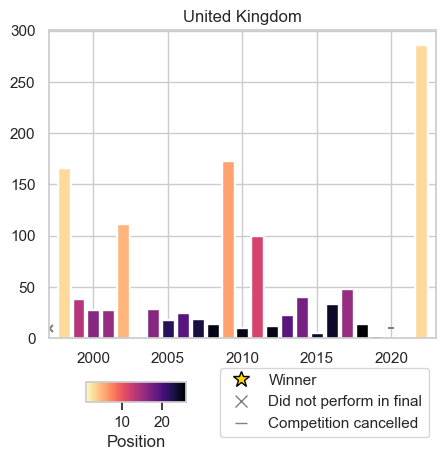

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True, sharex=True, squeeze=True)

plot_country('GB', ax, df)

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.2, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

# save to file
plt.savefig('../../plots/uk_scores.pdf', bbox_inches='tight')


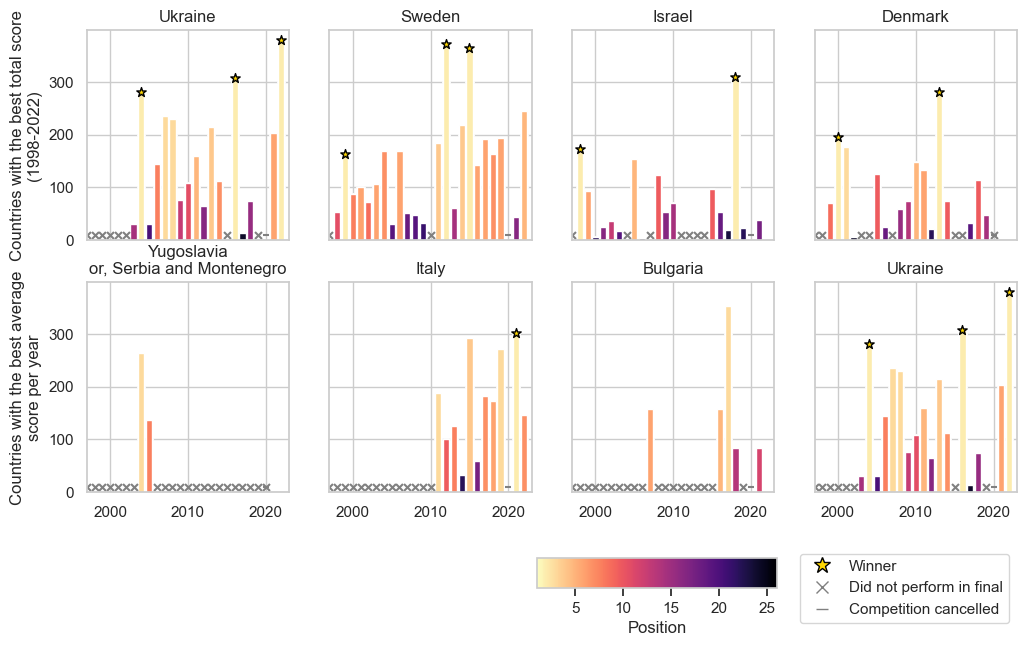

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True, squeeze=True)

plot_countries = winners['to_code2'].value_counts().loc[winners['to_code2'].value_counts() > 1].index

# add text for second row title
ax[0, 0].text(-0.3, 0.5, 'Countries with the best total score\n(1998-2022)', 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=ax[0, 0].transAxes, fontsize=12, rotation=90)
ax[1, 0].text(-0.3, 0.5, 'Countries with the best average\nscore per year', 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=ax[1, 0].transAxes, fontsize=12, rotation=90)

for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[0, i], df)

plot_countries = temp.groupby('to_code2')['total_points'].mean().sort_values(ascending=False).index[:4]
for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[1, i], df)

fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.5, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

ax[1][0].set_title("Yugoslavia\nor, Serbia and Montenegro")

plt.savefig('../../plots/top_performers_scores.pdf', bbox_inches='tight')


## Voting Country Deviations from Average Performance Scores

Calculate the voting deviations from the mean each country receives. 

In [23]:
df_voting= df[['from_country', 'points', 'to_country', 'year']].copy()

# The average votes for each To country
df_voting['avg_votes_per_pcountry'] = df_voting.groupby(['to_country'])['points'].transform('mean')

# The average votes for each To country
df_voting['avg_votes_per_pcountry_per country'] = df_voting.groupby(['to_country', 'from_country'])['points'].transform('mean')

# For each voting instance calculate the deviation from the average votes
df_voting['avg_difference_votes'] = df_voting['avg_votes_per_pcountry_per country'] - df_voting['avg_votes_per_pcountry']    

# If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
df_voting['no_instances'] = df_voting.groupby(['from_country', 'to_country'])['avg_difference_votes'].transform('count')
df_voting.loc[df_voting['no_instances'] < 3, 'avg_difference_votes'] = np.nan

df_voting.head()

,from_country,points,to_country,year,avg_votes_per_pcountry,avg_votes_per_pcountry_per country,avg_difference_votes,no_instances
0,belgium,5,croatia,1998,2.050725,0.833333,-1.217391,12
1,belgium,2,cyprus,1998,1.766667,1.200000,-0.566667,15
2,belgium,0,estonia,1998,2.624729,1.076923,-1.547806,13
3,belgium,0,north macedonia,1998,1.764901,0.000000,-1.764901,9
4,belgium,0,finland,1998,1.706009,1.461538,-0.244470,13


Average countries received 

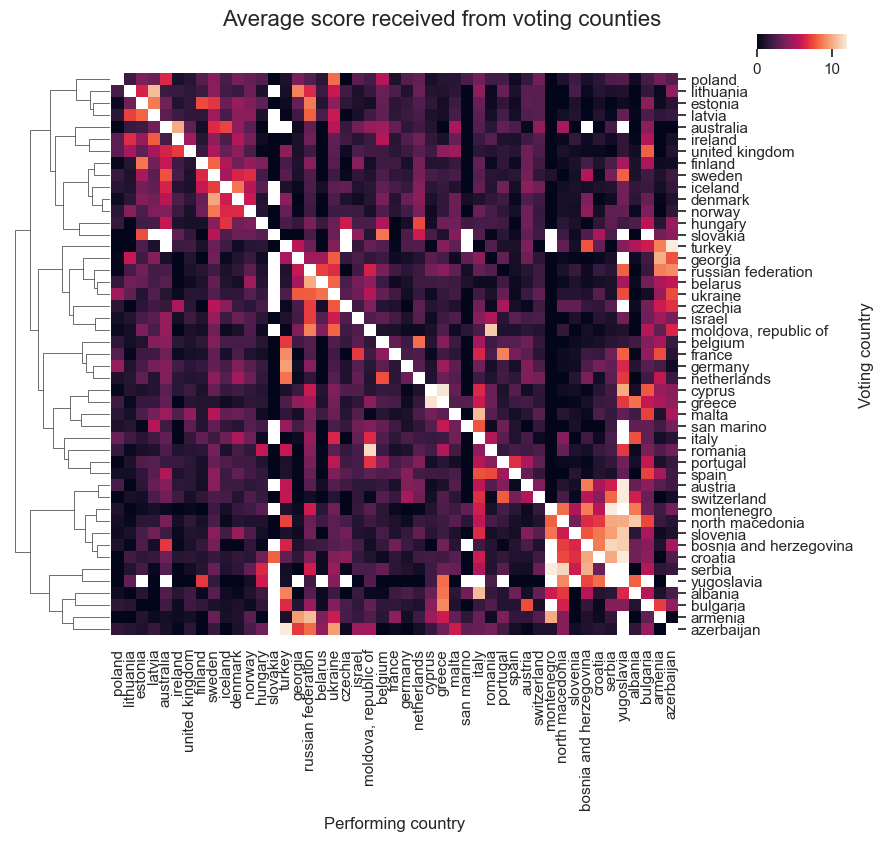

In [24]:
df_voting_heatmap = df_voting[['from_country', 'avg_votes_per_pcountry_per country', 'to_country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['from_country'] == df_voting_heatmap['to_country'], 'avg_votes_per_pcountry_per country'] = np.nan

df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_votes_per_pcountry_per country'])

df_heatmap = df_voting_heatmap.pivot(index='from_country', columns='to_country', values='avg_votes_per_pcountry_per country')

df_heatmap.head()

import scipy.spatial as sp, scipy.cluster.hierarchy as hc

df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')

plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(9,8), mask=df_heatmap2.isnull(), 
                dendrogram_ratio= [0.15, 0.01],
                cbar_pos = (0.85,1,0.1,.019), # x,y, delta x, delta y
                cbar_kws={"orientation": "horizontal"},
                #cmap='viridis', 
                #center=0, 
                xticklabels=1, yticklabels=1)

plot.ax_col_dendrogram.set_visible(False) 

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap


plot.fig.suptitle('Average score received from voting counties', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')
plot.ax_heatmap.set_xlabel('Performing country')

#plt.show()

plt.savefig('../../plots/deviation_from_average_received_scores.pdf', bbox_inches='tight')

Average deviations

In [25]:
df_voting_heatmap = df_voting[['from_country', 'avg_difference_votes', 'to_country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['from_country'] == df_voting_heatmap['to_country'], 'avg_difference_votes'] = np.nan

df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_difference_votes'])

df_heatmap = df_voting_heatmap.pivot(index='from_country', columns='to_country', values='avg_difference_votes')

df_heatmap.head()

to_country,albania,armenia,australia,austria,azerbaijan,belarus,belgium,bosnia and herzegovina,bulgaria,croatia,...,russian federation,san marino,serbia,slovenia,spain,sweden,switzerland,turkey,ukraine,united kingdom
from_country,,,,,,,,,,,,,,,,,,,,,
albania,NaN,-1.716775,-0.929752,-1.768099,-0.630292,-0.970085,-2.430751,2.812081,1.301478,-0.907867,...,-1.621569,2.719298,-1.439975,-1.269663,1.957285,-1.327451,0.975210,5.600664,-2.128149,0.447851
andorra,-1.738579,-2.625866,NaN,NaN,NaN,NaN,NaN,-2.521253,NaN,-2.050725,...,-1.954902,NaN,NaN,NaN,8.568396,-1.200000,NaN,-2.774336,1.434351,-0.441038
armenia,-1.738579,NaN,-2.763085,-0.982385,-2.847075,2.529915,-1.347418,-1.521253,-1.098522,-1.650725,...,6.166310,NaN,-1.248056,-1.269663,0.139825,-0.802564,0.432353,-2.474336,1.934351,-0.798181
australia,-1.738579,-2.625866,NaN,-2.232385,-2.937984,NaN,2.119249,NaN,0.151478,NaN,...,-1.288235,NaN,-0.636945,-1.269663,0.996968,2.538095,2.165686,NaN,1.334351,1.558962
austria,1.404278,0.088420,0.570248,NaN,-0.937984,-0.703419,-0.953478,6.228747,0.101478,2.949275,...,-1.645378,-0.614035,3.307499,-0.602996,-1.098270,0.022222,1.707353,2.350664,-1.527187,-0.107704


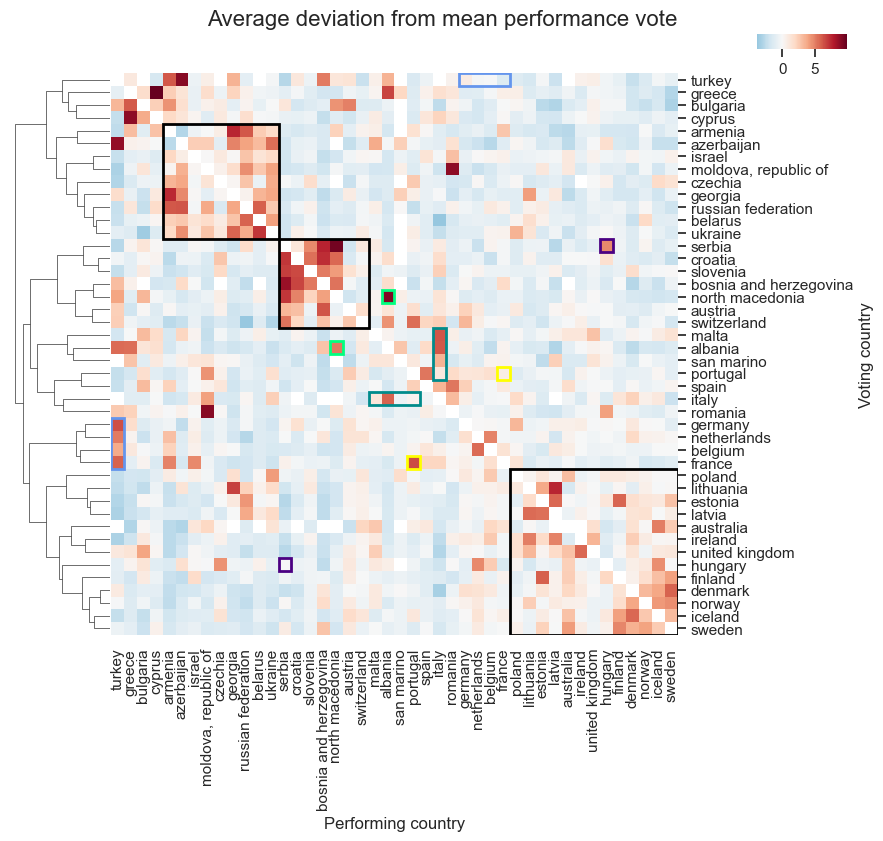

In [26]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')

plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(9,8), mask=df_heatmap2.isnull(), 
                dendrogram_ratio= [0.15, 0.01],
                cbar_pos = (0.85,1,0.1,.019), # x,y, delta x, delta y
                cbar_kws={"orientation": "horizontal"},
                cmap='RdBu_r', center=0, xticklabels=1, yticklabels=1)

plot.ax_col_dendrogram.set_visible(False) 

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap

ax.add_patch(Rectangle((4, 4), 9, 9, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((df_heatmap2.shape[1]-13, df_heatmap2.shape[1]-13), 13, 13, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((13, 13), 7, 7, fill=False, edgecolor='black', lw=2))

ax.add_patch(Rectangle((0, 27), 1, 4, fill=False, edgecolor='cornflowerblue', lw=2)) # turkey-germany, netherlands, belgium, france
ax.add_patch(Rectangle((27, 0), 4, 1, fill=False, edgecolor='cornflowerblue', lw=2))

ax.add_patch(Rectangle((20, 25), 4, 1, fill=False, edgecolor='darkcyan', lw=2)) # italy-malta, san marino, albania, portugal
ax.add_patch(Rectangle((25, 20), 1, 4, fill=False, edgecolor='darkcyan', lw=2))

ax.add_patch(Rectangle((13, 38), 1, 1, fill=False, edgecolor='indigo', lw=2)) # serbia-hungary
ax.add_patch(Rectangle((38, 13), 1, 1, fill=False, edgecolor='indigo', lw=2))

ax.add_patch(Rectangle((21, 17), 1, 1, fill=False, edgecolor='springgreen', lw=2)) # north-macedonia-albania
ax.add_patch(Rectangle((17, 21), 1, 1, fill=False, edgecolor='springgreen', lw=2))

ax.add_patch(Rectangle((30, 23), 1, 1, fill=False, edgecolor='yellow', lw=2)) # portugal-france
ax.add_patch(Rectangle((23, 30), 1, 1, fill=False, edgecolor='yellow', lw=2))

plot.fig.suptitle('Average deviation from mean performance vote', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')
plot.ax_heatmap.set_xlabel('Performing country')

#plt.show()

plt.savefig('../../plots/deviation_from_average_received_scores.pdf', bbox_inches='tight')

In this plot, countries are grouped by ... **TODO** 

There are a number of interesting details in this plot.
For example, the black boxes indicate that Turkey's entries have consistently obtained higher-than-average scores from Germany, the Netherlands, Belgium, and France; but that this isn't reciprocated.
A possible hypothesis for this may be the fact there is a significant Turkish diaspora in these countries: according to Pashayan (2012), there were 10 million "Euro-Turks" in these four countries in 2012.

This suggests that migration data between two countries might be another useful thing to look at.

REF (to be done up properly, and actually just ref 5 from https://en.wikipedia.org/wiki/Turkish_diaspora): Pashayan, Araks (2012), "Integration of Muslims in Europe and the Gülen", in Weller, Paul; Ihsan, Yilmaz (eds.), European Muslims, Civility and Public Life: Perspectives On and From the Gülen Movement, Continuum International Publishing Group, ISBN 978-1-4411-0207-2.

## Voting Pair Plots

In [63]:
countries = df['from_country'].unique()

# Create a new dataframe containing the data for the scatter plot
votes = pd.DataFrame({'performer': [], 'voter': [], 'times_competed': [], 'times_voted': [], 'total_points': [], 'average_points': []})

# Compare every country with every other country
for performer in countries:
    times_competed = len(df.loc[df['to_country'] == performer]['year'].unique())
    for voter in countries:
        times_voted = len(df.loc[(df['to_country'] == performer) & (df['from_country'] == voter) & (df['points'] > 0)])
        total_points = df.loc[(df['to_country'] == performer) & (df['from_country'] == voter)]['points'].sum()
        average_points = df.loc[(df['to_country'] == performer) & (df['points'] >= 0) & (df['from_country'] == voter)]['points'].mean()
        votes.loc[len(votes)] = [performer, voter, times_competed, times_voted, total_points, average_points]
print('Check every country is matched with very other: {}'.format(len(countries)**2 == len(votes)))

# Add the average points received overall for each country
votes = votes.merge(df.groupby('to_country')['points'].mean().reset_index(), 
    how='left', left_on='performer', right_on='to_country')

# Calculate the voting country's deviation from the average points given
votes.rename(columns={'points': 'overall_avgerage_points'}, inplace=True)
votes['deviation_from_average'] = votes['average_points'] - votes['overall_avgerage_points']

Check every country is matched with very other: True


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


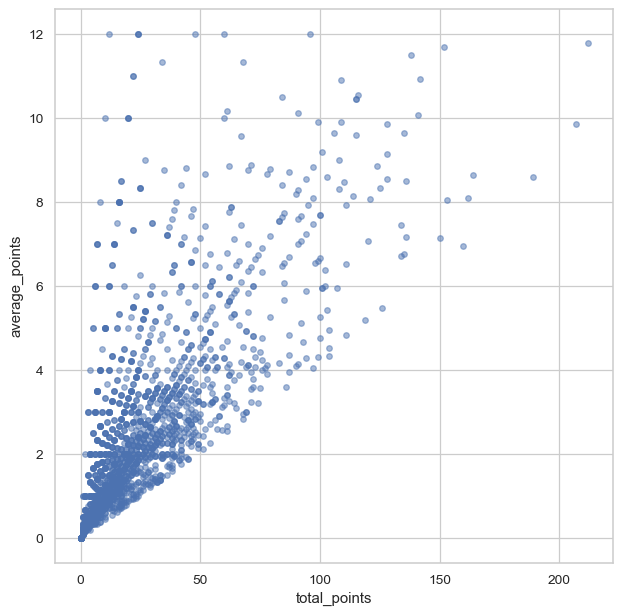

In [64]:
# Render a basic static scatter plot
fig = plt.figure(figsize=(8, 8), dpi=90)
votes.plot.scatter(x='total_points', y='average_points', alpha=0.5, ax = plt.gca())

plt.savefig('../../plots/total_vs_average_points.pdf', bbox_inches='tight')

In [65]:
import plotly.express as px

# Render an interactive (hoverable) plot
fig = px.scatter(votes, x='total_points', y='average_points')
fig.update_traces(hovertemplate='Performer: %{customdata[0]}'
                  + '<br>Voter: %{customdata[1]}'
                  + '<br>Total Eurovisions competed: %{customdata[2]}'
                  + '<br>Total times voted for by selected country: %{customdata[3]}'
                  + '<br>Total points given: %{customdata[4]}'
                  + '<br>Average points: %{customdata[5]:.2f}',
                  customdata=votes,
                  marker={'color': 'rgba(50, 50, 150, 0.1)', 'opacity': 0.5, 'size': 6,
                          'line': {'color': 'rgba(50, 50, 150, 1.0)', 'width': 1}})
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
                  xaxis={'title': 'Total voter points given to specific country'},
                  yaxis={'title': 'Average points'})
fig.show()

In [ ]:
# Plotly plot of performing countries on the y-axis and average votes received on the x-axis
votes = votes.sort_values(by='average_points', ascending=False)

fig = px.scatter(votes, x='average_points', y='performer', color='deviation_from_average', 
    color_continuous_scale=px.colors.diverging.RdYlGn,
    color_continuous_midpoint=0
)
fig.update_traces(hovertemplate='Performer: %{customdata[0]}'
    + '<br>Voter: %{customdata[1]}'
    + '<br>Total Eurovisions competed: %{customdata[2]}'
    + '<br>Total times voted for by selected country: %{customdata[3]}'
    + '<br>Total points given: %{customdata[4]}'
    + '<br>Average points by %{customdata[1]}: %{customdata[5]:.2f}'
    + '<br>Average points overall: %{customdata[7]:.2f}',
    customdata=votes)
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
    xaxis={'title': 'Average points received by selected country'},
    yaxis={'title': 'Performing Country'}, 
    coloraxis_colorbar=dict(title='Deviation from average points'))

fig.update_yaxes(tickfont_size=8)

fig.show()

## Looking for Country Friendships, Biases, and One-sided relationships

After looking at broader patterns, let's now dive into some specific country-pairs. 
We will look for the top country pairs which
* give each other very high scores
* give each other very low scores
* have a one-sided relationship, where one country gives high scores to another, but gets low scores back 

In [30]:
# filter for where bothfrom_country and to_country is turkey or armenia
(df
  .query('from_country == "armenia" & to_country == "turkey"')
)

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
5161,2006,Sibel Tüzün,armenia,turkey,0,91,11.0,AM,ARM,TR,...,female,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,2,True
6049,2007,Kenan Doğulu,armenia,turkey,0,163,4.0,AM,ARM,TR,...,male,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,3,True
7035,2008,Mor ve Ötesi,armenia,turkey,0,138,7.0,AM,ARM,TR,...,group,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,4,True
8085,2009,Hadise,armenia,turkey,4,177,4.0,AM,ARM,TR,...,female,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,5,True
9085,2010,maNga,armenia,turkey,0,170,2.0,AM,ARM,TR,...,group,789.0,73195345.0,0.000011,1250.0,2946293.0,0.000424,2010.0,6,True


In [31]:
# how often did each country participate?
n_participations = (df
                    .groupby('to_country')['year']
                    .nunique()
                    .sort_values(ascending=True))
# filter countries with less than 5 participations
countries_to_remove = n_participations[n_participations < 5].index.tolist()
# remove from df
df_pairs = df[~df['to_country'].isin(countries_to_remove)]
# get random 5 rows from df_pairs
df_pairs.sample(5)

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
17614,2018,Cláudia Pascoal feat. Isaura,georgia,portugal,0,23,23.0,GE,GEO,PT,...,group,1070.0,10358076.0,0.000103,NaN,NaN,NaN,NaN,0,False
2187,2002,Manuel Ortega,belgium,austria,5,26,18.0,BE,BEL,AT,...,male,1782.0,8011566.0,0.000222,2486.0,10251250.0,0.000243,2000.0,35,False
8975,2009,Waldo's People,turkey,finland,0,22,25.0,TR,TUR,FI,...,group,3569.0,5246096.0,0.000680,1610.0,68704715.0,0.000023,2005.0,2,False
18673,2019,Hatari,georgia,iceland,0,121,10.0,GE,GEO,IS,...,group,22.0,330815.0,0.000067,NaN,NaN,NaN,NaN,63,False
19904,2021,Go_A,lithuania,ukraine,12,203,5.0,LT,LTU,UA,...,group,24825.0,44132049.0,0.000563,20566.0,2794885.0,0.007358,2020.0,3,False


In [32]:
# Grouping by performer and voter, calculate mean votes and count number of years
df_pairs = (df_pairs
    .groupby(['from_country', 'to_country'])
    .agg(votes = ('points', 'mean'), num_years = ('year', 'count'))
    .reset_index()
    .sort_values('votes', ascending=False)
)

# Merge original dataframe with its reverse
df_pairs = (df_pairs
    .merge(df_pairs.rename(columns={'from_country': 'to_country', 
                               'to_country': 'from_country'}), 
           on=['from_country', 'to_country'])
    .drop_duplicates()
    .query('from_country != to_country')
    .assign(votes_diff = lambda x: abs(x['votes_x'] - x['votes_y']))
    .reindex(columns=['from_country', 'to_country', 'num_years', 'votes_x', 'votes_y', 'votes_diff'])
)

# create combined column with pairs in alphabetical order
df_pairs['country_pair'] = df_pairs[['from_country', 'to_country']].apply(lambda x: ' - '.join(sorted(x)), axis=1)
# Remove duplicate country pairs and the temporary country_pair column
df_pairs = (df_pairs
            .drop_duplicates(subset=['country_pair'])
            .drop(columns=['country_pair']))

df_pairs.head()

,from_country,to_country,num_years,votes_x,votes_y,votes_diff
0,azerbaijan,turkey,NaN,12.000000,12.000000,0.000000
2,cyprus,greece,NaN,11.777778,11.692308,0.085470
4,romania,"moldova, republic of",NaN,11.500000,10.923077,0.576923
5,serbia,north macedonia,NaN,11.333333,9.909091,1.424242
6,bosnia and herzegovina,serbia,NaN,11.333333,10.166667,1.166667


In [33]:
# Number of country pairs to show for each category
N = 5

# top 5 country pairs with high votes for each other
top_highs = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=False).head(N)
)

# top 5 country pairs with low votes for each other
top_lows = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=True).head(N)
)

# top 5 unbalanced country pairs (one gives high votes to the other, but gets low votes back)
top_one_sided = (df_pairs
            .sort_values('votes_diff', ascending=False).head(N))

# combine 
top_relationships = (pd.concat([top_highs, top_lows, top_one_sided]))
# add grouping
top_relationships['group'] = ['high'] * N + ['low'] * N + ['one-sided'] * N

# sort by votes_x
top_relationships = top_relationships.sort_values('votes_x')

top_relationships['y'] = range(1, len(top_relationships) + 1)

top_relationships

,from_country,to_country,num_years,votes_x,votes_y,votes_diff,group,y
1662,italy,turkey,NaN,0.000000,0.000000,0.000000,low,1
1632,romania,georgia,NaN,0.000000,0.000000,0.000000,low,2
1620,albania,lithuania,NaN,0.090909,0.000000,0.090909,low,3
1621,armenia,azerbaijan,NaN,0.090909,0.000000,0.090909,low,4
1612,belarus,ireland,NaN,0.125000,0.000000,0.125000,low,5
32,turkey,armenia,NaN,8.800000,0.800000,8.000000,one-sided,6
26,france,turkey,NaN,9.142857,0.200000,8.942857,one-sided,7
21,germany,turkey,NaN,9.642857,2.466667,7.176190,one-sided,8
16,australia,ireland,NaN,10.000000,2.166667,7.833333,one-sided,9
9,malta,italy,NaN,10.545455,3.500000,7.045455,one-sided,10


In [34]:
# Replace group names with numeric values for sorting
group_order = {'low': 1, 'one-sided': 2, 'high': 3}
top_relationships['group_order'] = top_relationships['group'].replace(group_order)

# Create a new column representing the minimum value between 'votes_x' and 'votes_y'
top_relationships['min_votes'] = top_relationships[['votes_x', 'votes_y']].min(axis=1)

# Sort the DataFrame by 'group_order' and 'min_votes'
top_relationships = top_relationships.sort_values(by=['group_order', 'min_votes'], ascending=[True, True])

# Reassign the 'y' column after sorting
top_relationships['y'] = range(1, len(top_relationships) + 1)

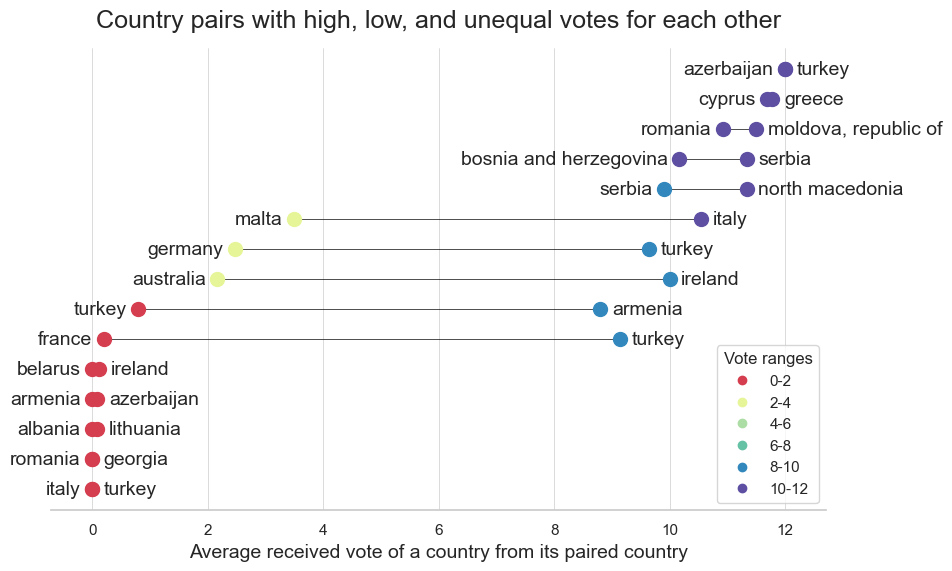

In [35]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(axis='x', linestyle='-', linewidth=0.5)

# create a color map with 6 colors from red to blue
colors = sns.color_palette("YlOrRd", 6)[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=len(colors))

# get color map with viridis colors for 6 bins
cmap = plt.get_cmap('viridis' )

#colors = ["#b2182b", "#d1e5f0", "#92c5de", "#4393c3", "#2166ac", "#053061" ]
colors = ["#d53e4f", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=len(colors))


# define the range boundaries
bins = np.arange(0, 13, 2)

# add text labels and points
for i, row in top_relationships.iterrows():
    ax.text(row['votes_x']+0.2, row['y'] ,row['to_country'],  ha='left', va='center', fontsize=14)  # increase the value added to 'votes_x' for more space
    ax.text(row['votes_y']-0.2, row['y'] , row['from_country'],  ha='right', va='center', fontsize=14)  # increase the value subtracted from 'votes_y' for more space

    # plot points with colors based on x-value range
    x_color = np.digitize(row['votes_x'], bins=bins, right=True)-1
    y_color = np.digitize(row['votes_y'], bins=bins, right=True)-1
    ax.scatter(row['votes_x'], row['y'], color=cmap(x_color/6), s=100, alpha=1, zorder=3)
    ax.scatter(row['votes_y'], row['y'], color=cmap(y_color/6), s=100, alpha=1, zorder=3)

    # add line between countries with slightly shortened length
    line_buffer = 0.1
    ax.plot([row['votes_x'] + line_buffer, row['votes_y'] - line_buffer], [row['y'], row['y']], color='black', alpha=0.7, zorder=2, linewidth=0.7)

ax.set_xlabel('Average received vote of a country from its paired country', fontsize=14)
ax.set_ylabel('')

# Hide the y axis
ax.get_yaxis().set_visible(False)
ax.spines[['top', 'right', 'left']].set_visible(False)

# Add legend
markers = [plt.Line2D([0,0],[0,0], color=cmap(i/6), marker='o', linestyle='') for i in range(6)]
plt.legend(markers, ['{}-{}'.format(i, i+2) for i in bins[:-1]], numpoints=1, loc='lower right', title='Vote ranges')

plt.title('Country pairs with high, low, and unequal votes for each other', fontsize=18,  loc='center', pad=15)

fig.savefig('../../plots/country_relationships.pdf', bbox_inches='tight')

The plot shows the top 5 pairs of countries which give each other high, low and unequal scores.
The point next to a country name is the score it *received* from the other country. For example, both France and Germany on average get low scores from Turkey, but give Turkey high scores.
Cyprus and Greece give each other high scores, and Albania and Lithuania tend to give each other low scores.

The plot differs a bit from the results above, because it is looking at raw votes, not deviations from the mean vote.
Therefore, one-sided voting does not necessarily indicate bias in voting: it may simply be because the country has historically performed very well (or very poorly!) in Eurovision.

# Migration Data

 **TODO** Maybe plot prop_emigrants versus the score deviation?

One of our main goals was to predict the winner of the 2023 contest. On a finer scale, this means predicting how each country will vote for each other country. Arguably, countries with a large immigrant population from another country might give more favorable votes to that country. To test and incorporate this in our models, we used migration data from [Our World in Data](https://ourworldindata.org/migration). Specifically, we were interested in the proportion of immigrants in each country from each other country. We calculated both sides, i.e. proportion emigrants from the voter country in the perfomer country (v2p) and the other way round.

In [36]:
# migration data
df.filter(like='migr').head()

,migration_v2p,prop_emigrants_v2p,migration_p2v,prop_emigrants_p2v,migration_pop_year
0,205.0,0.000044,72.0,0.000007,1995.0
1,92.0,0.000107,77.0,0.000008,1995.0
2,0.0,0.000000,57.0,0.000006,1995.0
3,NaN,NaN,120.0,0.000012,1995.0
4,144.0,0.000028,1541.0,0.000152,1995.0


In [37]:
df_migration = df[['year', 'from_code2', 'to_code2', 'prop_emigrants_v2p', 'prop_emigrants_p2v', 'points']].copy()

# Calculate score deviation per year
df_migration['avg_votes'] = df_migration.groupby(['to_code2', 'year'])['points'].transform('mean')
df_migration['deviation'] = df_migration['points'] - df_migration['avg_votes']


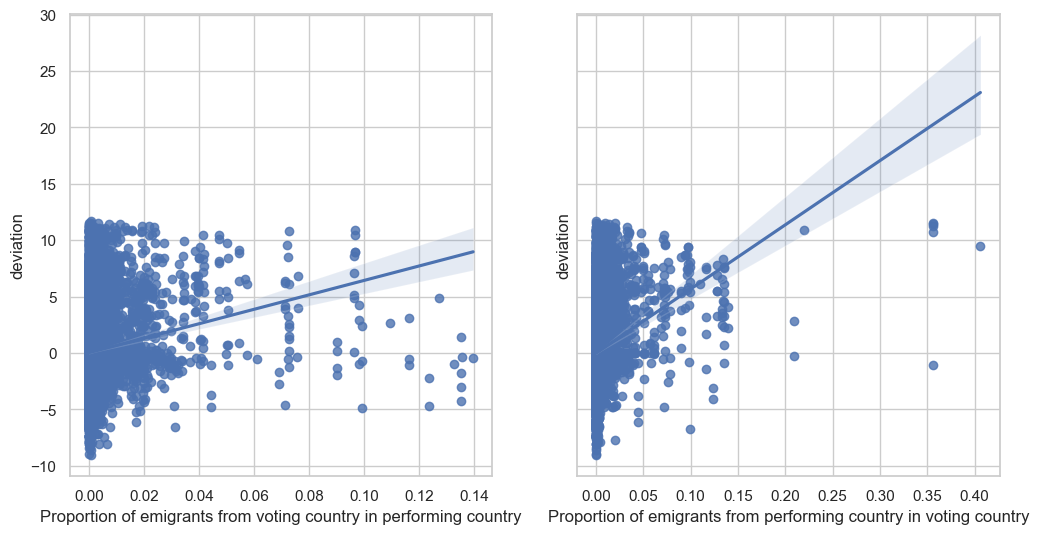

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x='prop_emigrants_v2p', y='deviation', data=df_migration, ax=ax1)
sns.regplot(x='prop_emigrants_p2v', y='deviation', data=df_migration, ax=ax2)

ax1.set_xlabel('Proportion of emigrants from voting country in performing country')
ax2.set_xlabel('Proportion of emigrants from performing country in voting country')

#plt.show()

plt.savefig('../../plots/emigration.pdf', bbox_inches='tight')

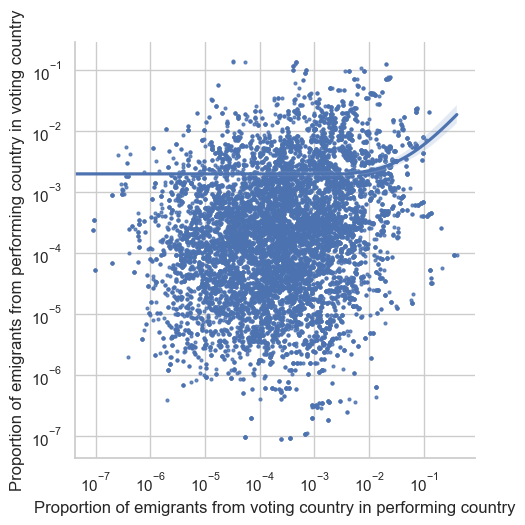

In [39]:
sns.lmplot(x='prop_emigrants_p2v', y='prop_emigrants_v2p', data=df_migration, scatter_kws={"s": 4})

# log scale axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Proportion of emigrants from voting country in performing country")
plt.ylabel("Proportion of emigrants from performing country in voting country")
plt.show()

# Language Data

We are interested in three things:
1. Does the song contain english lyrics: yes vs no &#x2705;
2. What are the average votes for songs with english lyrics vs non-english lyrics &#x2705;
3. Does the performer sing in their official language yes vs no (english) vs no (non-english) &#x2705;
4. How many languages appear in the song vs votes? (can you hedge your bets?) &#x2705;
5. Are the votes received affected by whether or not a song is sung in the voting country's official language? &#x2705;

**TODO** Get language data cleaned up, see https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/issue-5-exploratory_visualisations/eurovision/notebooks/language_visualistaions.ipynb.

**TODO** Discussion of Eurovision language rules (this has changed over time).

In this dataset, we have categorised the song language into one or more of: the country's official language (`own`), English (`eng`), or an entirely separate language (`other`).
When English *is* one of the country's official languages, both `own` and `other` are selected.
We can use this data to investigate how likely each country is to perform in English:

In [40]:
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 
       'rank', 'to_code2',
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

In [41]:
df_performance.loc[df_performance['year'] == 2018]['to_country'].value_counts()

to_country
australia               1
austria                 1
united kingdom          1
ukraine                 1
sweden                  1
spain                   1
slovenia                1
serbia                  1
portugal                1
norway                  1
netherlands             1
moldova, republic of    1
lithuania               1
italy                   1
israel                  1
ireland                 1
hungary                 1
germany                 1
france                  1
finland                 1
estonia                 1
denmark                 1
czechia                 1
cyprus                  1
bulgaria                1
albania                 1
Name: count, dtype: int64

In [42]:
# get the percentage of performances who contain own language
print('Percentage of performances in own language:', round(sum(df_performance['Contains_Own_Language'])/len(df_performance) *100), '%')
print('Percentage of performances in English:', round(sum(df_performance['Contains_English'])/len(df_performance) *100), '%')

print('Percentage of performances by gender:')
df_performance['gender'].value_counts()/len(df_performance) * 100

Percentage of performances in own language: 46 %
Percentage of performances in English: 76 %
Percentage of performances by gender:


gender
female    40.000000
male      30.333333
group     29.666667
Name: count, dtype: float64

In [43]:
df_language = df_performance.copy()

df_performance['English_only'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] == 1 )
df_performance['No_English'] = ~df_performance['Contains_English'] 
df_performance['Some_English'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] > 1 )

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'English_only': 'mean', 'Some_English': 'mean', 'No_English': 'mean'})

df_language = df_language.sort_values(by=['English_only', 'Some_English'], ascending=True)

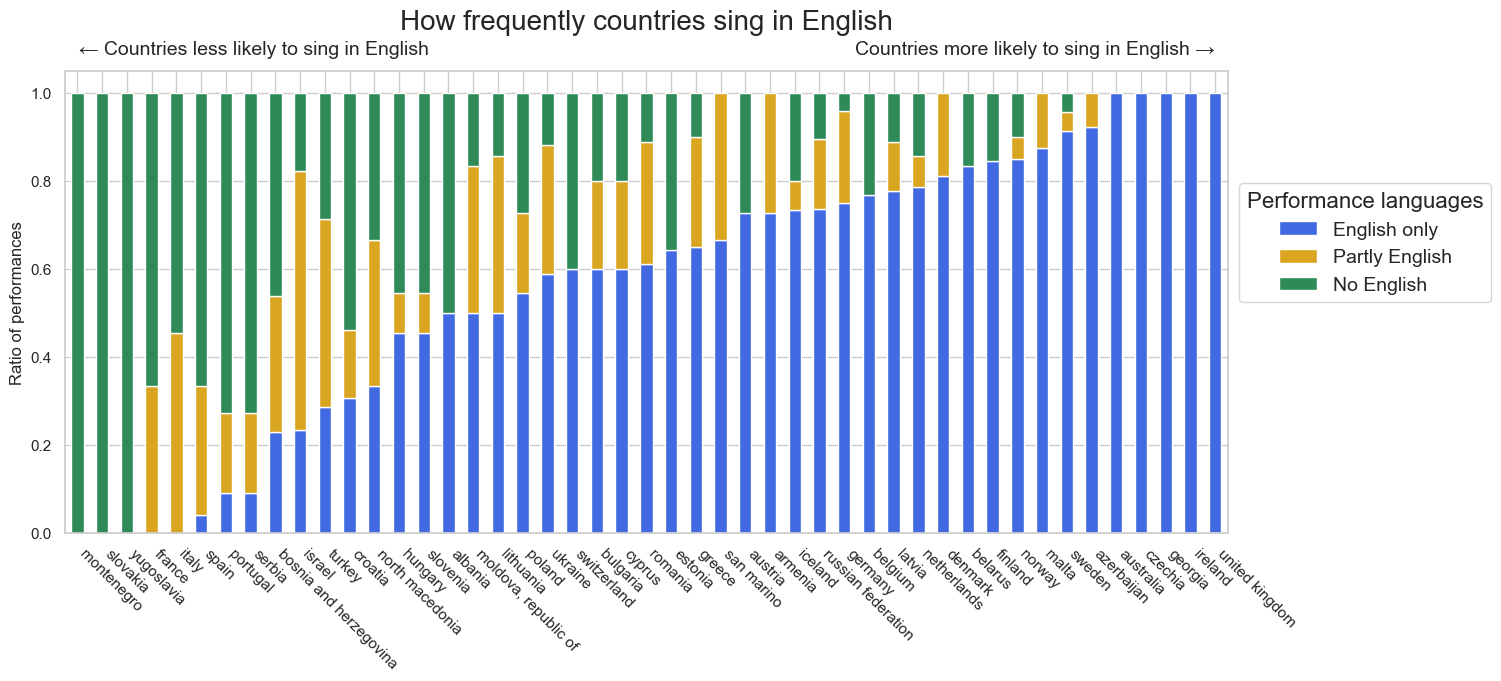

In [44]:
colours = {"English_only":'royalblue', "No_English":'seagreen', "Some_English":'goldenrod'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['English only', 'Partly English', 'No English'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in English', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in English →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in English ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

#plt.show()

plt.savefig('../../plots/english_performances.pdf', bbox_inches='tight')

In [45]:
# convert wide to long format
df_long = df_performance[['English_only', 'No_English',	'Some_English', 'total_points']]

df_long = df_long.melt(id_vars=['total_points'], var_name='language', value_name='contains_language')

df_long['contains_language'] = df_long['contains_language'].astype(int)

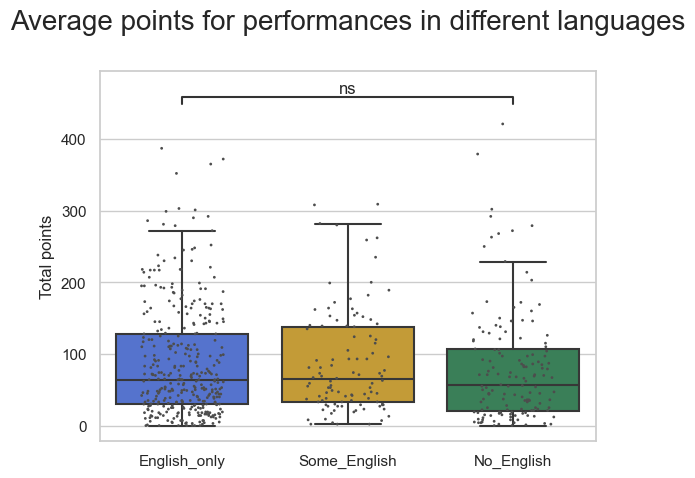

In [46]:
import scipy.stats as stats
from statannot import add_stat_annotation

# boxplots for each language type
ax = sns.boxplot(x='language', y='total_points', 
                 data=df_long.loc[df_long['contains_language'] > 0], 
                 palette=colours, showfliers=False, 
                 order=['English_only', 'Some_English', 'No_English'])
sns.stripplot(x='language', y='total_points', 
              order=['English_only', 'Some_English', 'No_English'],
              data=df_long.loc[df_long['contains_language'] > 0], 
              jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Average points for performances in different languages', fontsize=20, pad=30)
plt.xlabel('')
plt.ylabel('Total points')

add_stat_annotation(ax, data=df_long.loc[df_long['contains_language'] > 0],
                    x='language', y='total_points', 
                    order=['English_only', 'Some_English', 'No_English'],
                    box_pairs=[("English_only", "No_English")],
                    test='Mann-Whitney', text_format='star', verbose=0)

plt.show()

In [47]:
df_language = df_performance.copy()

df_performance['Own_language'] = (df_performance['Contains_Own_Language']) 
df_performance['Other_language'] = ~df_performance['Contains_Own_Language'] 

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'Other_language': 'mean', 'Own_language': 'mean'})

df_language = df_language.sort_values(by=['Own_language', 'Other_language'], ascending=True)

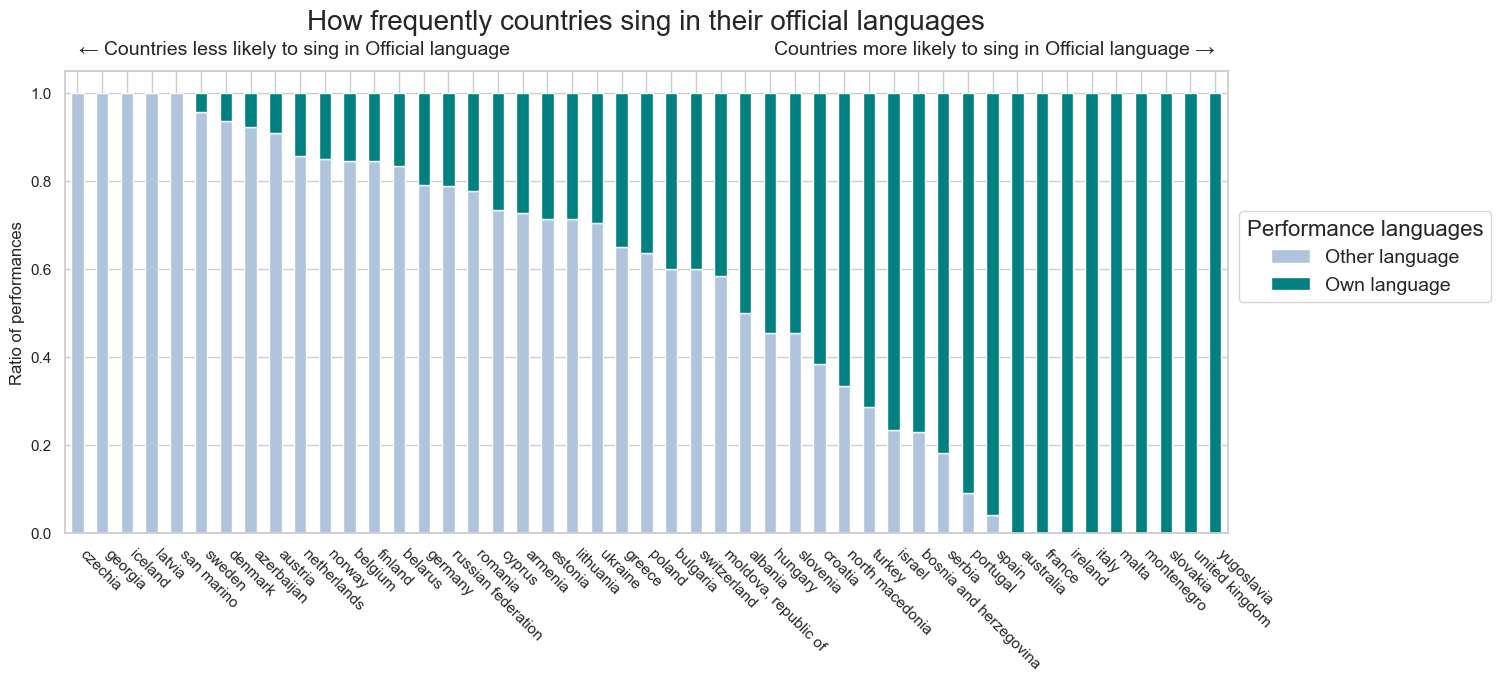

In [48]:
colours = {"Own_language":'teal', "Other_language":'lightsteelblue'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['Other language', 'Own language'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in their official languages', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in Official language →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in Official language ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

#plt.show()

plt.savefig('../../plots/official_languages.pdf', bbox_inches='tight')

Typically those on the left of this plot are countries who sing in english but english is not their official language. Those on the right are countries who sing in their official language exclusively.

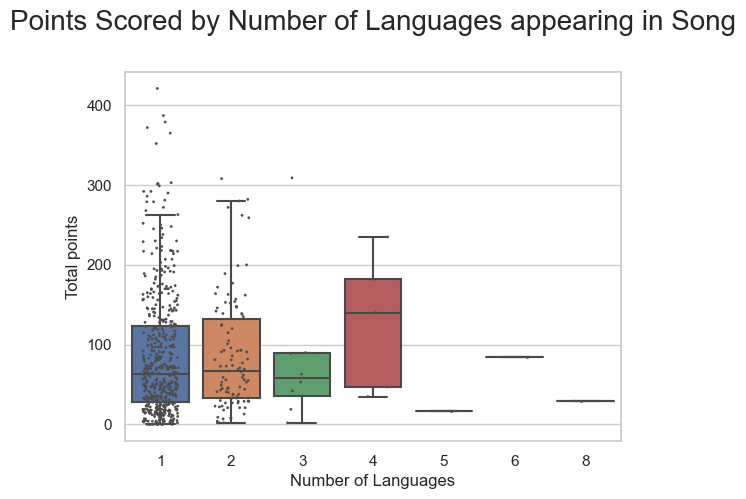

In [49]:
sns.boxplot(x='Number_of_Languages', y='total_points', data=df_performance, showfliers=False)
sns.stripplot(x='Number_of_Languages', y='total_points', data=df_performance, jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Points Scored by Number of Languages appearing in Song', fontsize=20, pad=30)
plt.xlabel('Number of Languages')
plt.ylabel('Total points')


plt.show()
#plt.savefig('../../plots/uk_scores.pdf', bbox_inches='tight')

<AxesSubplot:xlabel='Contains_Voting_Language', ylabel='points'>

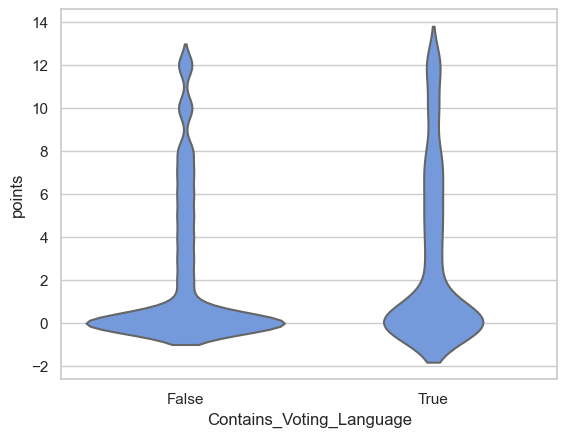

In [50]:
# violin plot
sns.violinplot(x='Contains_Voting_Language', y='points', data=df, inner=None, color="cornflowerblue")

# Gender Data

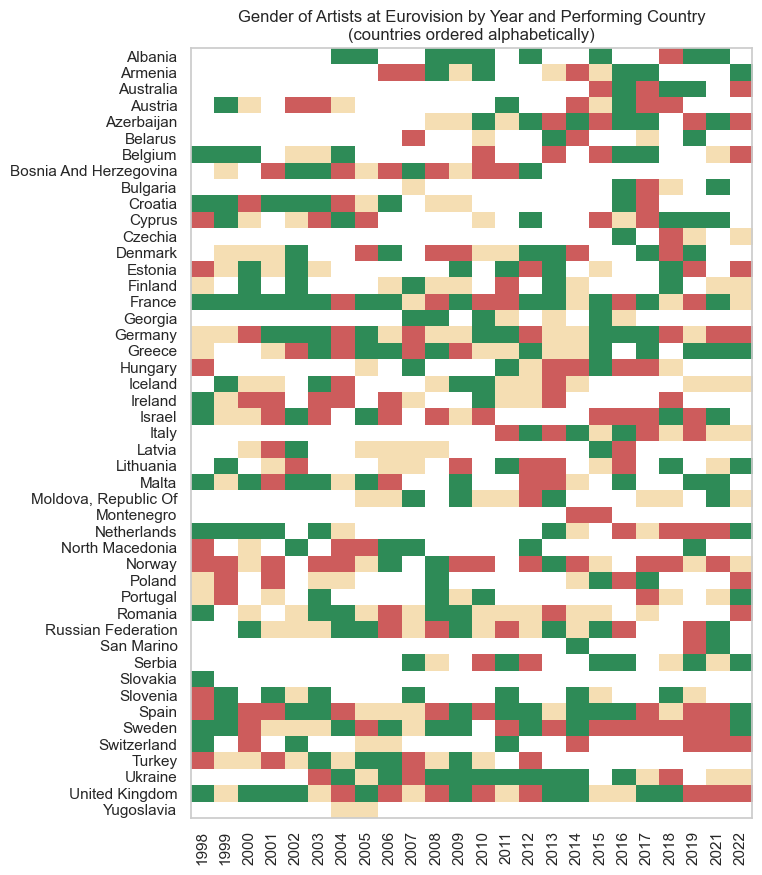

In [51]:
from matplotlib.colors import to_rgba

gender_df = df[['year', 'to_country', 'gender']].copy().drop_duplicates()

countries = gender_df.sort_values(by=['to_country'])['to_country'].drop_duplicates().to_list()
years = gender_df['year'].drop_duplicates().to_list()

gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred'),
    'none': to_rgba('white')
}

gender = []
for year in years:
    missing = pd.DataFrame({'year': [year] * len(countries), 'to_country': countries, 'gender': ['none'] * len(countries)}).set_index('to_country')
    missing.update(gender_df[gender_df['year'] == year].set_index('to_country'))
    gender.append(list(map(lambda x: gender_colours[x], missing.sort_values(by=['to_country'])['gender'].to_list())))

gender = list(map(list, zip(*gender)))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
img = plt.imshow(gender, aspect=0.7)
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)
plt.xticks(rotation=90)
ax.set_yticks(range(len(countries)))
ax.set_yticklabels(list(map(str.title, countries)))
ax.grid(False)
plt.title('Gender of Artists at Eurovision by Year and Performing Country\n(countries ordered alphabetically)')
#plt.show()


plt.savefig('../../plots/performance_genders.pdf', bbox_inches='tight')

In [52]:
for gender in ['female', 'male', 'group']:
    count = len(gender_df[gender_df['gender'] == gender])
    print('Total {} performers: {} ({:.0%})'.format(gender, count, count/len(gender_df)))

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('to_country').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)
gender_df = gender_df.sort_values(by=['female', 'group'], ascending=False)

gender_df.head()

Total female performers: 240 (40%)
Total male performers: 182 (30%)
Total group performers: 178 (30%)


,female,group,male
to_country,,,
slovakia,1.000000,0.000000,0.000000
albania,0.900000,0.000000,0.100000
san marino,0.666667,0.000000,0.333333
slovenia,0.636364,0.272727,0.090909
ukraine,0.588235,0.235294,0.176471


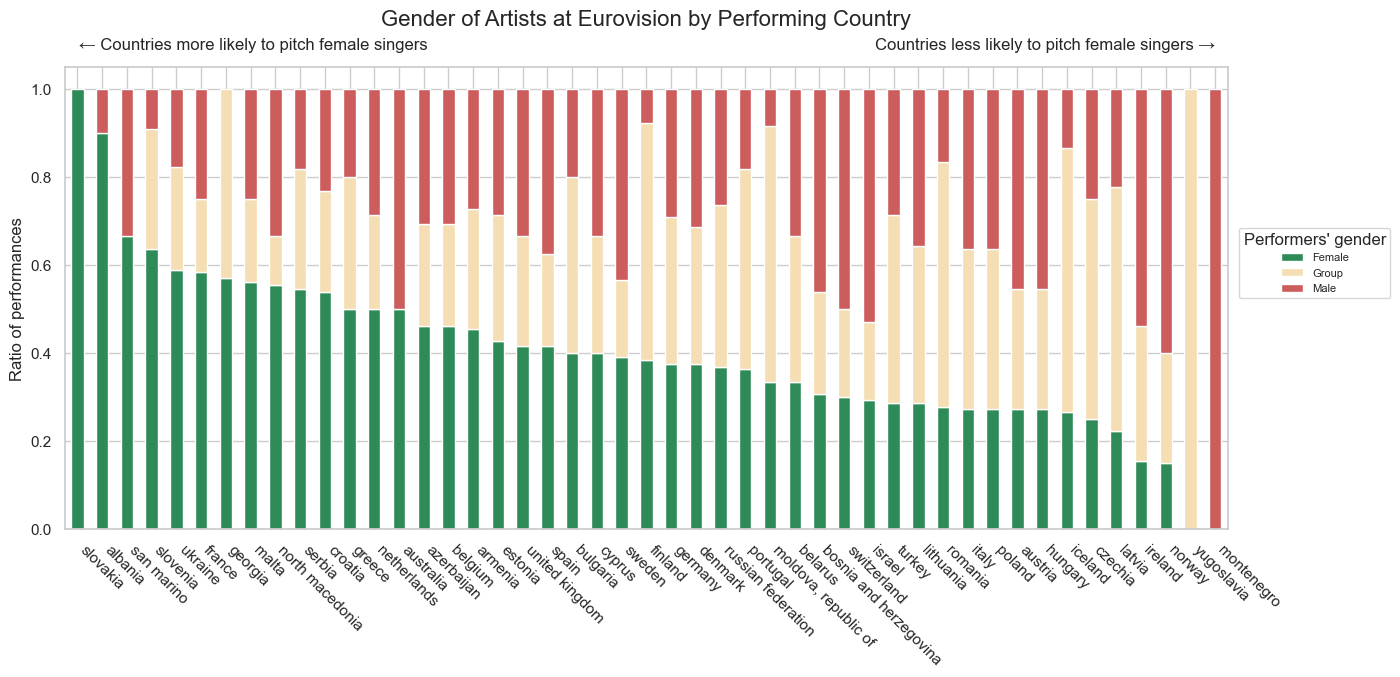

In [53]:
gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred')#,
    #'none': to_rgba('white')
}

gender_df[gender_colours.keys()].plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)
plt.text(gender_df.shape[0] - 1, 1.1, 'Countries less likely to pitch female singers →', ha='right', va='center', fontsize=12)
plt.text(0.05, 1.1, '← Countries more likely to pitch female singers', ha='left', va='center',  fontsize=12)
plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Performing Country', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')
#plt.show()


plt.savefig('../../plots/gender_ratios.pdf', bbox_inches='tight')

In [54]:
gender_df = df[['year', 'to_code2', 'gender']].copy().drop_duplicates()

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('year').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)

gender_df.head()

,female,group,male
year,,,
1998,0.480000,0.200000,0.320000
1999,0.478261,0.391304,0.130435
2000,0.333333,0.416667,0.250000
2001,0.260870,0.347826,0.391304
2002,0.583333,0.291667,0.125000


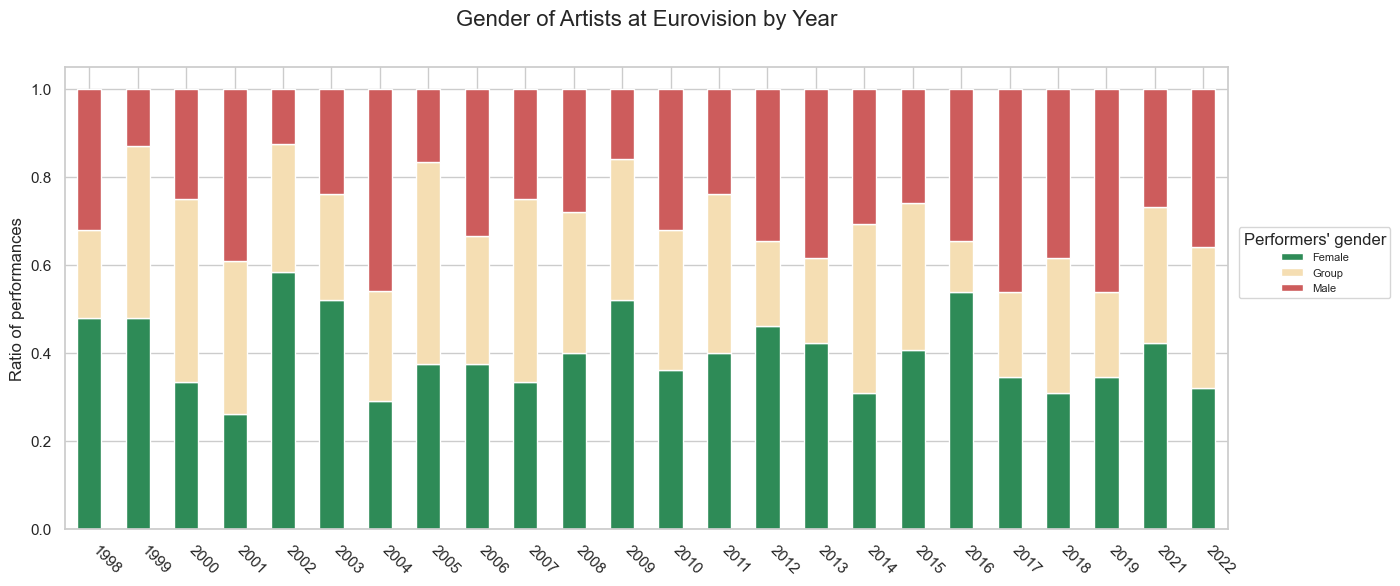

In [55]:
# subset gender_colours to genders in gender_df columns
# gender_colours = gender_colours[gender_df.columns.to_list()]

gender_df.plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)

plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Year', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')
#plt.show()

plt.savefig('../../plots/gender_by_year.pdf', bbox_inches='tight')

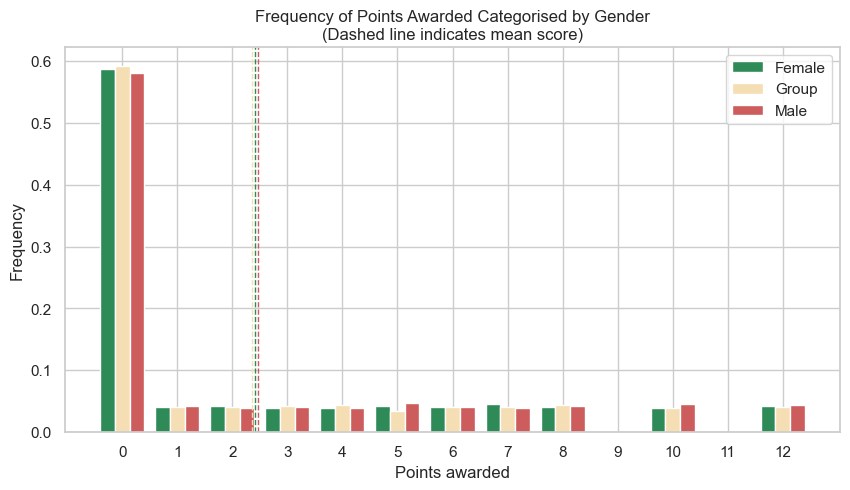

In [56]:
gender_df = df[['year', 'to_code2', 'gender', 'points']].copy()
genders = list(gender_colours.keys())[:3]
votes = []
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
for gender in genders:
    votes_df = gender_df[gender_df['gender'] == gender]['points']
    votes.append(votes_df)
    plt.axvline(votes_df.mean(), color=gender_colours[gender], linestyle='dashed', linewidth=1)

plt.hist(votes, density=True, bins=range(14), color=list(gender_colours.values())[:3], label=[gender.title() for gender in genders], align='left')
plt.xlabel('Points awarded')
plt.ylabel('Frequency')
plt.title('Frequency of Points Awarded Categorised by Gender\n(Dashed line indicates mean score)')
plt.legend()
plt.xticks(range(13))
ax.set_xticklabels([str(i) for i in range(13)])
#plt.show()

plt.savefig('../../plots/gender_points.pdf', bbox_inches='tight')

In [57]:
# TODO: check if male get higher average votes. 

# Collective Visualisations

- Heatmap for correlation plot
- Martin's plot
- Geographical plots
- Scatter plots

In [58]:
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 'rank', 'to_code2', 
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'prop_emigrants_v2p', 'prop_emigrants_p2v', 'has_border',
       'comps_without_win',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

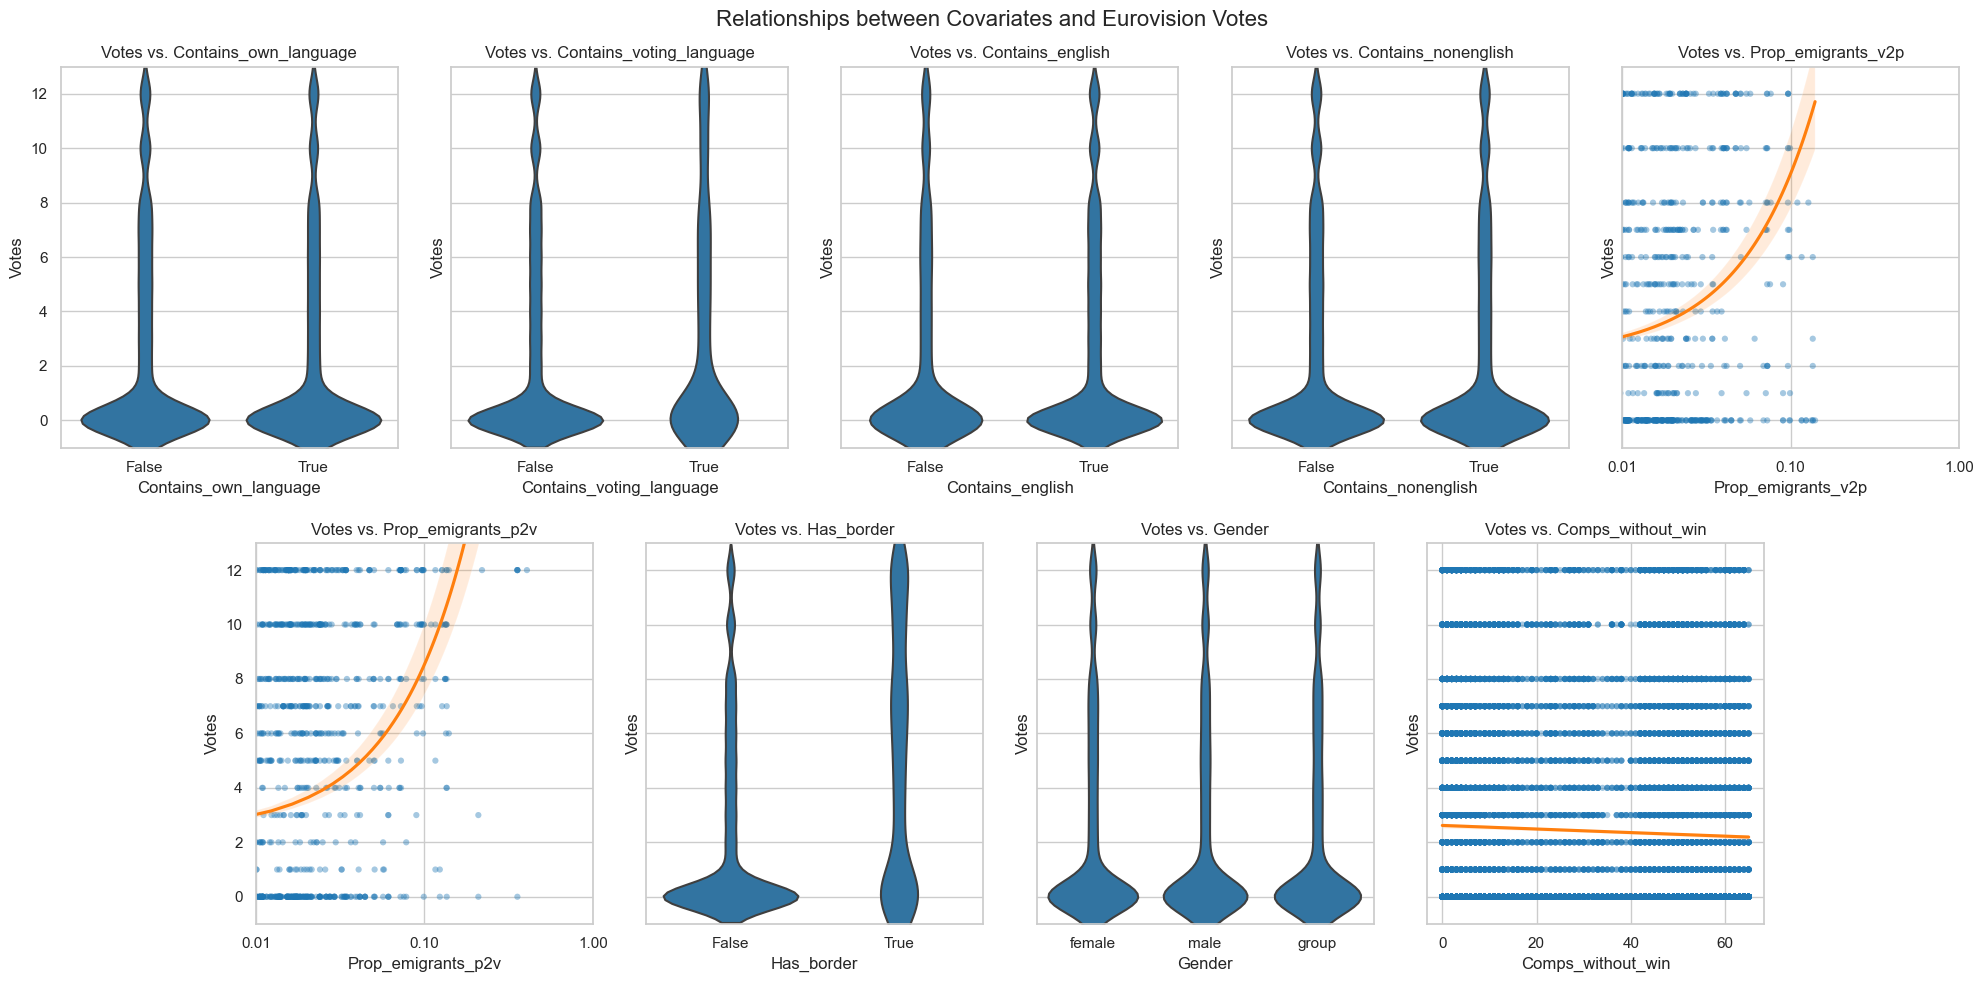

In [59]:
import matplotlib

# Define the variables of interest and their data types
vars_of_interest = {
    'Contains_Own_Language': 'binary',
    'Contains_Voting_Language': 'binary',
    'Contains_English': 'binary',
    'Contains_NonEnglish': 'binary',
    'prop_emigrants_v2p': 'numeric', 
    'prop_emigrants_p2v': 'numeric', 
    'has_border': 'binary',
    'gender': 'categorical', 
    'comps_without_win': 'numeric'
}

# Define the figure and axes
nc = int(np.ceil(len(vars_of_interest)/2))
fig, axes = plt.subplots(nrows=2, ncols=nc, figsize=(20, 10), sharey=True)

# Loop through the dictionary
for i, (key, value) in enumerate(vars_of_interest.items()):
    j, k = 0, i
    if i > (nc - 1):
        j, k = 1, i - nc

    if value == 'categorical':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    elif value == 'binary':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    else:
        sns.regplot(ax=axes[j, k], x=key, y='points', data=df, ci=95, 
                    color='tab:blue', scatter_kws={'alpha': 0.4, 'edgecolor': 'none', 's': 20}, 
                    line_kws={'color': 'tab:orange'})

        # if key contains Prop then log scale x axis
        if key.startswith('prop'):
            axes[j, k].set_xscale('log')
            axes[j, k].set_xticks([0.01, 0.1, 1, 10, 100])
            axes[j, k].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            axes[j, k].set_xlim(0.01, 1)

    axes[j, k].set_ylim(-1, 13)
    axes[j, k].set_xlabel(key.capitalize())
    axes[j, k].set_ylabel('Votes')
    axes[j, k].set_title(f'Votes vs. {key.capitalize()}')

fig.suptitle('Relationships between Covariates and Eurovision Votes', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Shuffle the bottom row along there are an odd number of variables
if len(vars_of_interest) % 2 == 1:
    axes[1][-1].remove()
    # distance between two axes
    if len(vars_of_interest) >= 3:
        dist = axes[0][1].get_position().x0 - axes[0][0].get_position().x0
        for ax in axes[1]:
            pos = ax.get_position()
            ax.set_position([pos.x0 + (dist / 2), pos.y0, pos.width, pos.height])

#plt.show()

plt.savefig('../../plots/covars_vs_votes.pdf', bbox_inches='tight')

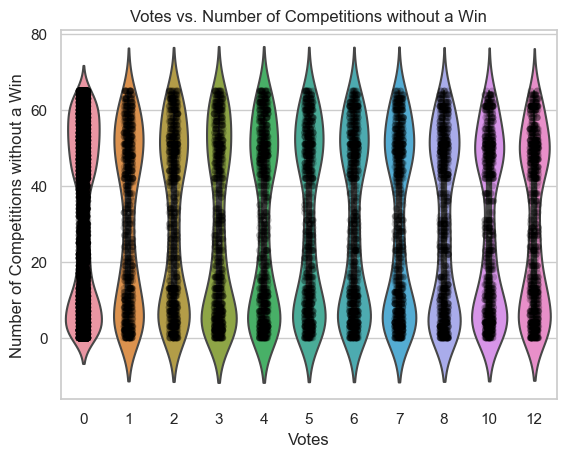

In [60]:
# plot comps_without_win vs. points
sns.violinplot(x='points', y='comps_without_win', data=df)
# add jitter
sns.stripplot(x='points', y='comps_without_win', data=df, jitter=True, color='black', alpha=0.2)

plt.title('Votes vs. Number of Competitions without a Win')
plt.ylabel('Number of Competitions without a Win')
plt.xlabel('Votes')
plt.show()


In [61]:
df[['points', 'comps_without_win']].corr()

,points,comps_without_win
points,1.000000,-0.040708
comps_without_win,-0.040708,1.000000


In [62]:
# correlation plot of numeric and binary variables
df_corr = df[['points', 'rank',
       'total_points', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language',
       'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'has_border',
       'comps_without_win']].corr()

# heatmap of the correlation matrix
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'fontsize': 7})

# replace _ in labels with space
labels = [label.replace('_', ' ').title() for label in df_corr.columns]
plt.xticks(np.arange(len(labels)), labels, rotation=-45, ha='left', va='top')
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0, va='center')


#plt.show()

plt.savefig('../../plots/covar_correlation_plot.pdf', bbox_inches='tight')



ValueError: could not convert string to float: 'female'

# Modelling

[...]

# Conclusions

Round everything up, draw conclusions.